# Two hyperplanes trading bot

## Model
$x(t) \in \mathbb{R}^n$ represent the n-dimension curve, which means the feature of market at time $t$.

There are two planes  ${w}^T(x-p)=0$ and ${u}^T(x-q)=0$ called trading planes, which partition $\mathbb{R}^n$ into 4 regions.
$${w}^T(x-p)>=0 \; and \; {u}^T(x-q)>=0 : Buy\;region $$
$${w}^T(x-p)>=0 \; and \; {u}^T(x-q)<0 : Hold\;region $$
$${w}^T(x-p)<0 \; and \; {u}^T(x-q)<0 : Sell\;region $$
$${w}^T(x-p)<0 \; and \; {u}^T(x-q)>=0 : Hold\;region $$

## Estimate
To determine the two hyperplanes, we need to uniquely determine the unit normal vector ${w}$, ${u}$ and shift ${p}$, ${q}$.  The philosophy of the strategy is $x(t)$ oscillate in feature space like the market.  The center point should be choose as the average of the feature space, denoted by ${p}^*$

So the two hyperplanes are modelde as ${w}^T(x-{p}^*)$ and ${u}^T(x-{p}^*)$.  The next step is to determine the two unit vector ${w}$ and ${u}$.  Let's use [CMA-ES](https://en.wikipedia.org/wiki/CMA-ES)

## Action and Objective
The definition of objective function can be set as $$\frac{r - \bar{r}}{\lambda(\sigma + \bar{\sigma})}$$
$r$ represent the annualized return, ${\sigma}$ is the annualized **downward** volatility, $\lambda$ is the panelty of the downward volatility.  For a given period $[0, T]$, there are serveral simple mode to help calculate the loss function:
- Spot mode:
  - Initial fund is 50%, 50% of the asset of token, USDT.
  - Once $x(t)$ first enter buy space, use all USDT to buy token.  Otherwise, sell all token to USDT
- Perp mode (1):
  - Initial position is 0
  - Once $x(t)$ first enter buy space, enter long position with position 1, Hold until $x(t)$ enter sell space and reverse the position
- Perp model (2):
  - Initial position is 0
  - Once $x(t)$ is in buy space, the position is 1.  Else if $x(t)$ is in hold space, position is 0, else $x(t)$ is in sell space, the position is -1.


## MLOps
To identify the effectiveness, there should be a series of MLOps for time-series, let's skip this part and address in next notebook.

## Risk management
Skip first and will address in the future notebook

## Backtest and Production
After finding the two hyperplanes, we can determine the actual strategy by study the geometry to elaborate the parameters like quantity, or the strength of the signal to determine whether we can buy or skip the buy.  Some geometry are list below:
$$\frac{d}{dt} x(t) \;tangent\;of\;x(t)$$
$$\left\| \frac{d}{dt} x(t) \right\| \;speed\;of\;x(t)$$
$$\int_{a}^{b} \left\| \frac{d\mathbf{x}}{dt} \right\| \, dt\;arc length\;of\;x(t)$$
and other geometry like period of a buy-sell cycle, projection from $x(t)$ to buy/sell planes, etc

## Report
A report should contains some MLOps statistics, but we can still deliver some financial index like: return, volatility, MDD and sharpe ratio for reference.
In spot, we can benchmark the portfolio with holding BTC, holding ETH.



# Finding Hyperplanes


In [80]:
# The load hourly data from 2023-05-01 00:00:00 to 2023-10-30 23:59:59 because this peroid is diversified enough and we test from 2023-11-01 00:00:00 to 2024-2-28 23:59:59
from backtest.components.core import ZipKLineIterator
from backtest.components import KLineMarket

from datetime import datetime, timezone
import pandas as pd

start_time = datetime(2023, 4, 1, tzinfo=timezone.utc).timestamp() * 1000  # Load one month in advance to do feature engineering
end_time = datetime(2024, 2, 1, tzinfo=timezone.utc).timestamp() * 1000 - 1
data_source = '/home/yite/crypto_data/binance/data'
kline_iterator = ZipKLineIterator('BTCUSDT', start_time, end_time, data_source)
df = kline_iterator.to_dataframe()
df = df[["open", "high", "low", "close", "volume", "open_time", "close_time"]]
df['date'] = pd.to_datetime(df['open_time'], unit='ms')
df.set_index('date', inplace=True)


In [81]:
# Feature Engineering, here use MACD in TaLib
import talib
help(talib.MACD)

Help on function MACD in module talib._ta_lib:

MACD(real, fastperiod=-2147483648, slowperiod=-2147483648, signalperiod=-2147483648)
    MACD(real[, fastperiod=?, slowperiod=?, signalperiod=?])
    
    Moving Average Convergence/Divergence (Momentum Indicators)
    
    Inputs:
        real: (any ndarray)
    Parameters:
        fastperiod: 12
        slowperiod: 26
        signalperiod: 9
    Outputs:
        macd
        macdsignal
        macdhist



In [82]:
df['macd'], df['macdsignal'], _ = talib.MACD(df['close'])

In [84]:
start_date = '2023-05-01 00:00:00'
end_date = '2023-10-30 23:59:59'

# Querying the DataFrame
train = df.loc[start_date:end_date]

start_date = '2023-11-01 00:00:00'
end_date = '2024-01-31 23:59:59'
test = df.loc[start_date:end_date]
test

,open,high,low,close,volume,open_time,close_time,macd,macdsignal
date,,,,,,,,,
2023-11-01 00:00:00,34639.78,34668.05,34500.15,34507.68,1514.98495,1698796800000,1698800399999,47.025654,23.168249
2023-11-01 01:00:00,34507.67,34557.11,34465.62,34492.07,813.73754,1698800400000,1698803999999,43.838717,27.302343
2023-11-01 02:00:00,34492.08,34494.20,34426.09,34450.03,646.51710,1698804000000,1698807599999,37.488624,29.339599
2023-11-01 03:00:00,34450.04,34466.03,34400.00,34418.40,772.84636,1698807600000,1698811199999,29.563069,29.384293
2023-11-01 04:00:00,34418.39,34464.97,34386.44,34439.57,715.07737,1698811200000,1698814799999,24.705462,28.448527
...,...,...,...,...,...,...,...,...,...
2024-01-31 18:00:00,43715.04,43745.11,43474.13,43513.38,1499.79579,1706724000000,1706727599999,67.222340,-32.105865
2024-01-31 19:00:00,43513.38,43551.99,43041.10,43334.64,2549.59458,1706727600000,1706731199999,75.367470,-10.611198
2024-01-31 20:00:00,43334.63,43361.10,42519.92,42541.18,3928.70425,1706731200000,1706734799999,17.594139,-4.970130


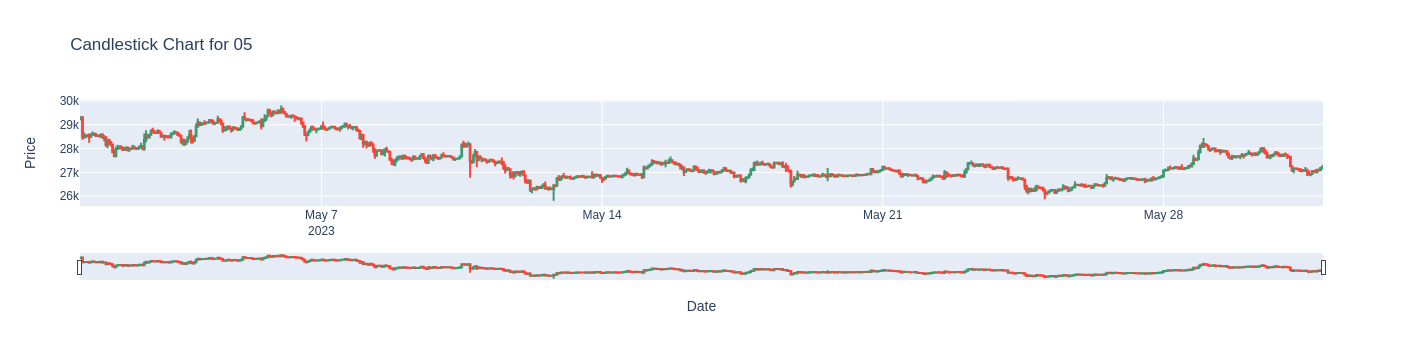

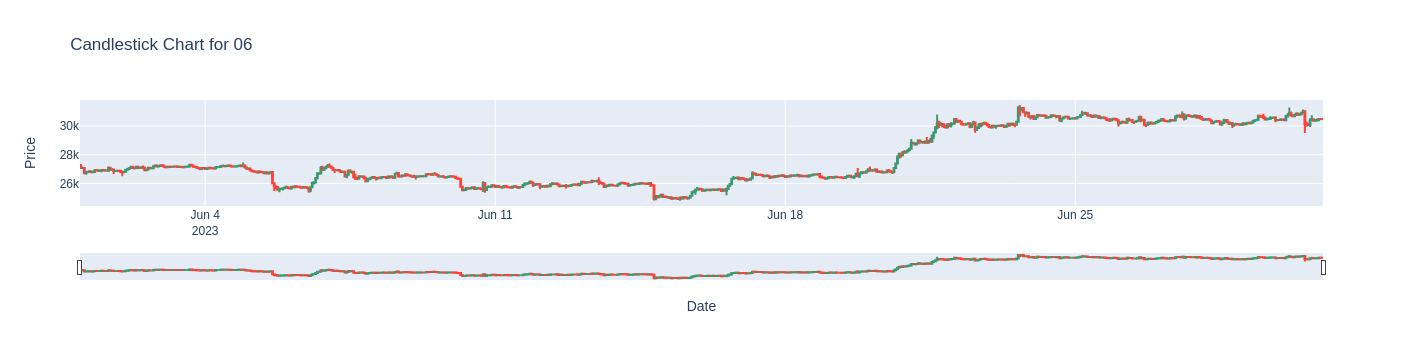

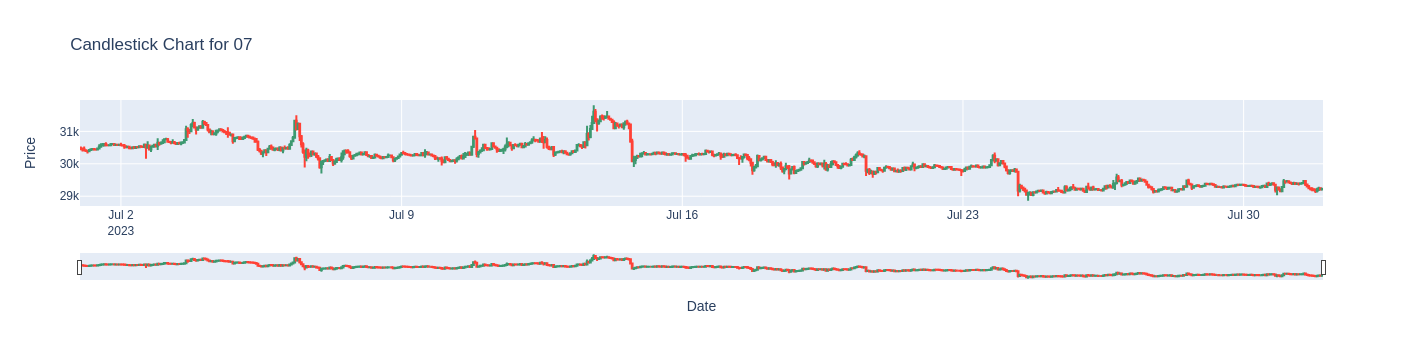

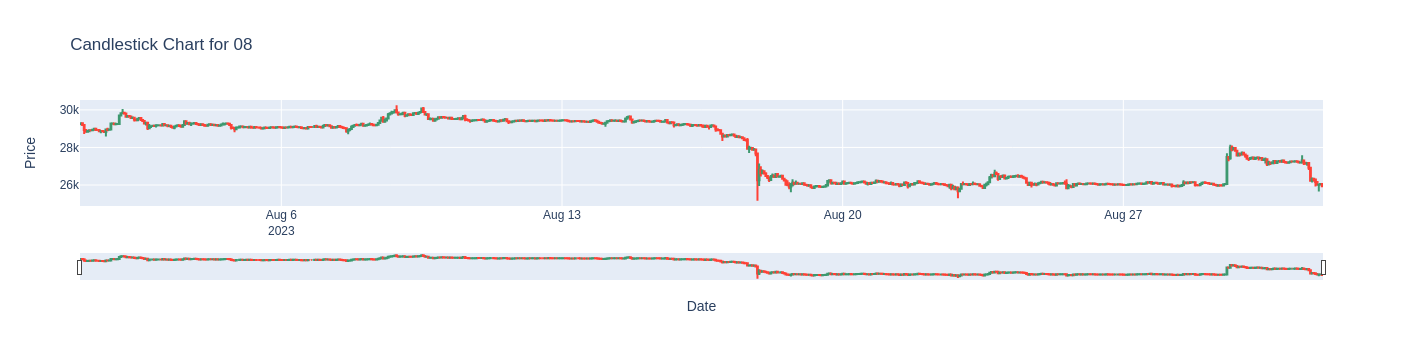

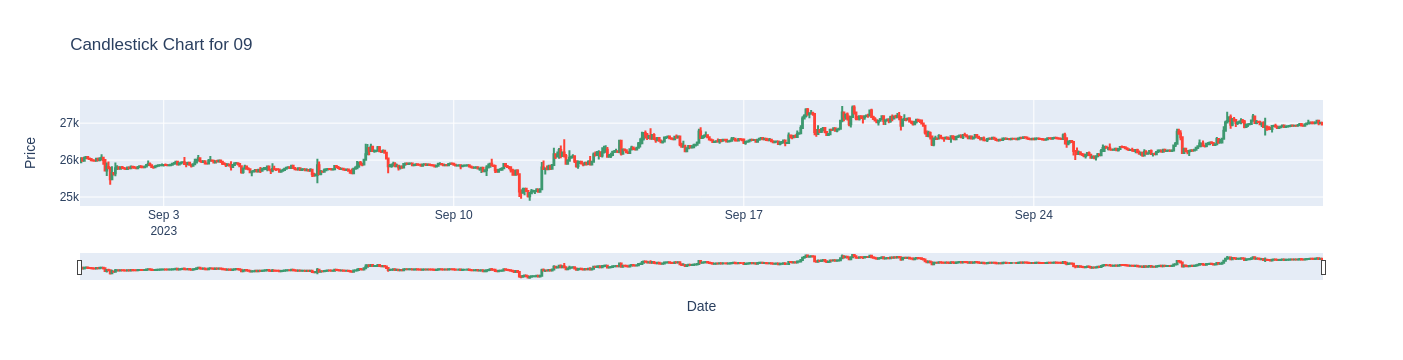

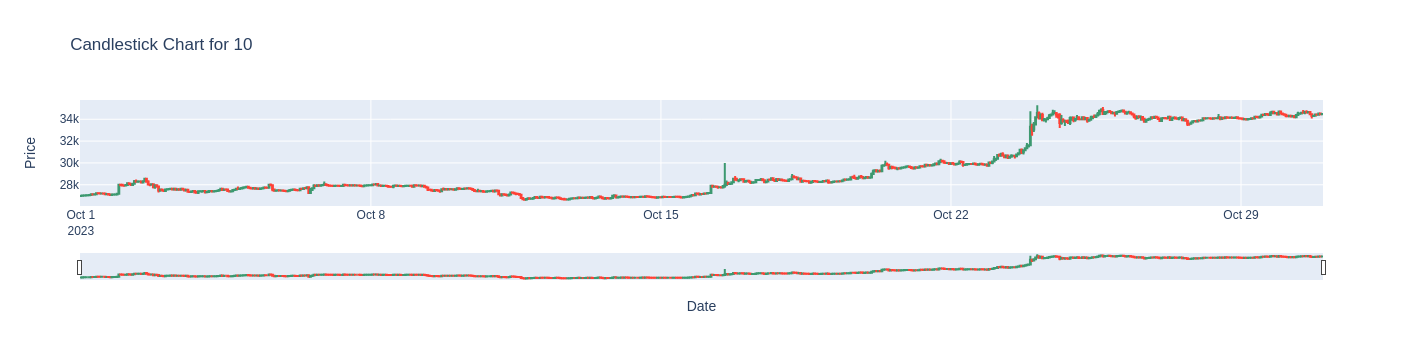

In [85]:
import plotly.graph_objects as go

months = train.index.month.unique()
for month in months:
    # Filter data for the specific month and year
    monthly_data = train[(train.index.month == month)]
    # Check if there is data for the month
    if not monthly_data.empty:
        # Create a candlestick chart for the month
        fig = go.Figure(data=[go.Candlestick(x=monthly_data.index,
                                             open=monthly_data['open'],
                                             high=monthly_data['high'],
                                             low=monthly_data['low'],
                                             close=monthly_data['close'])])
        # Update layout with the title indicating the month and year
        fig.update_layout(title=f'Candlestick Chart for {month:02d}',
                          xaxis_title='Date',
                          yaxis_title='Price')
        # Show the plot
        fig.show()

In [137]:
import numpy as np
# Determine p*
# p = np.array([df['macd'].median(), df['macdsignal'].median()])
p_train = np.array([train['macd'].mean(), train['macdsignal'].mean()])

p_test = np.array([test['macd'].mean(), test['macdsignal'].mean()])
p_train, p_test

(array([8.12499601, 8.13895374]), array([27.44464471, 27.51170692]))

In [138]:
# Prepare objective function
import numpy as np
from backtest.ffn import calc_interval_return, calc_interval_volatility

def spot_strategy(strategy: pd.DataFrame):
    eps = 1e-5
    asset = {'token': 1_000 / strategy['open'].iloc[0], 'usdt': 1_000}
    portfolio = []
    for idx, event in strategy.iterrows():
        price = event["close"]
        if event["strategy"] == "Hold":
            pass
        elif asset['usdt'] > eps and event["strategy"] == "Buy":
            usdt_amt = asset['usdt']
            btc_amt = usdt_amt / price
            asset['token'] += btc_amt
            asset['usdt'] -= usdt_amt
        elif asset['token'] > eps / price and event["strategy"] == "Sell":
            btc_amt = asset['token']
            usdt_amt = btc_amt * price
            asset['token'] -= btc_amt
            asset['usdt'] += usdt_amt
        portfolio.append({"open_time": event["open_time"]} | asset | {"value": asset["token"] * price + asset["usdt"]})
    portfolio = pd.DataFrame(portfolio)
    r = calc_interval_return(portfolio, 'open_time', 'value', '365d')
    v = calc_interval_volatility(portfolio, 'open_time', 'value', '365d')
    return r, v
    

def objective_function(u: np.array, v: np.array, p: np.array, q: np.array, market: pd.DataFrame, *features): # u, v are normal vector and 
    df = market.copy()
    df['buy'] = df[list(features)] @ u
    df['sell'] = df[list(features)] @ v
    df['buy_signal'] = df['buy'] > 0
    df['sell_signal'] = df['sell'] > 0
    # Apply logic to create strategy column
    df['strategy'] = df.apply(
        lambda row: "Buy" if row['buy_signal'] == True and row['sell_signal'] == False 
                    else ("Sell" if row['buy_signal'] == False and row['sell_signal'] == True 
                          else "Hold"), 
        axis=1
    )
    r, v = spot_strategy(df)
    return r, v
    

In [139]:
u = np.array([1, 0])
v = np.array([0, 1])
objective_function(u, v, p_train, p_train, train, 'macd', 'macdsignal')

(-0.11411087399423617, 0.2242856774045553)

In [140]:
import optuna
import numpy as np

class ObjectiveHandler:
    def __init__(self, p: np.array, market: pd.DataFrame, *features):
        self.features = list(features)
        self.p = market[self.features].mean().to_numpy()
        self.market = market
        
        

    def spot_statistics(self, u, v):  # Should be more general
        df = self.spot_strategy(u, v)
        r, v = self._spot_return(df)
        return {
            "return": r,
            "volatility": v
        }

    def spot_strategy(self, u, v):
        u = u / np.sqrt(u @ u)
        v = v / np.sqrt(v @ v)
        df = self.market.copy()
        df['buy'] = df[self.features] @ u
        df['sell'] = df[self.features] @ v
        df['buy_signal'] = df['buy'] > 0
        df['sell_signal'] = df['sell'] > 0
        # Apply logic to create strategy column
        df['strategy'] = df.apply(
            lambda row: "Buy" if row['buy_signal'] == True and row['sell_signal'] == False 
                        else ("Sell" if row['buy_signal'] == False and row['sell_signal'] == True 
                              else "Hold"), 
            axis=1
        )
        return df
        

    def _spot_return(self, strategy: pd.DataFrame):
        eps = 1e-5
        asset = {'token': 1_000 / strategy['open'].iloc[0], 'usdt': 1_000}
        portfolio = []
        for idx, event in strategy.iterrows():
            price = event["close"]
            if event["strategy"] == "Hold":
                pass
            elif asset['usdt'] > eps and event["strategy"] == "Buy":
                usdt_amt = asset['usdt']
                btc_amt = usdt_amt / price
                asset['token'] += btc_amt
                asset['usdt'] -= usdt_amt
            elif asset['token'] > eps / price and event["strategy"] == "Sell":
                btc_amt = asset['token']
                usdt_amt = btc_amt * price
                asset['token'] -= btc_amt
                asset['usdt'] += usdt_amt
            portfolio.append({"open_time": event["open_time"]} | asset | {"value": asset["token"] * price + asset["usdt"]})
        portfolio = pd.DataFrame(portfolio)
        r = calc_interval_return(portfolio, 'open_time', 'value', '365d')
        v = calc_interval_volatility(portfolio, 'open_time', 'value', '365d')
        return r, v


In [141]:
# Initialize the handler with the training set
handler_training = ObjectiveHandler(p_train, train, 'macd', 'macdsignal')
handler_testing = ObjectiveHandler(p_test, test, 'macd', 'macdsignal')
trial_performance = {'training': [], 'testing': []}

def objective(trial):
    # Suggest values for a 2-dimensional x
    u1 = trial.suggest_float('u1', -1, 1)
    u2 = trial.suggest_float('u2', -1, 1)

    v1 = trial.suggest_float('v1', -1, 1)
    v2 = trial.suggest_float('v2', -1, 1)
    
    # Create the vector x
    u = np.array([u1, u2])
    v = np.array([v1, v2])
    training_stats = handler_training.spot_statistics(u, v)
    testing_stats = handler_testing.spot_statistics(u, v)

    # Store performances
    trial_performance['training'].append(training_stats)
    trial_performance['testing'].append(testing_stats)
    return training_stats["return"] - 0 * training_stats["volatility"]

def print_testing_performance(study, trial):
    latest_testing_stats = trial_performance['testing'][-1]
    print(f"Trial {trial.number}, Testing Set Performance: {latest_testing_stats}")

    

# Create a study, specifying the CMA-ES sampler
sampler = optuna.samplers.CmaEsSampler()
study = optuna.create_study(sampler=sampler, direction='maximize')
 
# Optimize the objective function
study.optimize(objective, n_trials=300, callbacks=[print_testing_performance])

[I 2024-03-24 00:17:47,228] A new study created in memory with name: no-name-c6dba472-f17a-466c-b8a9-28908ce598e5
[I 2024-03-24 00:17:47,508] Trial 0 finished with value: 0.095443188962453 and parameters: {'u1': 0.9067355133970851, 'u2': -0.40485677110171436, 'v1': -0.6959466168045068, 'v2': 0.001530737900163004}. Best is trial 0 with value: 0.095443188962453.


Trial 0, Testing Set Performance: {'return': 0.5693165528780599, 'volatility': 0.3427156033845874}


[I 2024-03-24 00:17:47,764] Trial 1 finished with value: -0.26006774025706536 and parameters: {'u1': 0.08209550845664593, 'u2': 0.007557724683330935, 'v1': 0.1671741761607961, 'v2': 0.27252682863760214}. Best is trial 0 with value: 0.095443188962453.


Trial 1, Testing Set Performance: {'return': 0.24321138534634798, 'volatility': 0.3433433311646989}


[I 2024-03-24 00:17:48,024] Trial 2 finished with value: 0.9495124814843208 and parameters: {'u1': 0.042140288704919815, 'u2': 0.1471473193855295, 'v1': 0.07178655831456537, 'v2': 0.4218610456027241}. Best is trial 2 with value: 0.9495124814843208.


Trial 2, Testing Set Performance: {'return': -0.25848320482355186, 'volatility': 0.20552626609251484}


[I 2024-03-24 00:17:48,306] Trial 3 finished with value: 0.10489257219140544 and parameters: {'u1': 0.09443189198165713, 'u2': -0.2513623933723108, 'v1': -0.18811239182187278, 'v2': 0.63275036325416}. Best is trial 2 with value: 0.9495124814843208.


Trial 3, Testing Set Performance: {'return': 0.2504622902528277, 'volatility': 0.2992925548063167}


[I 2024-03-24 00:17:48,562] Trial 4 finished with value: -0.3507633080927209 and parameters: {'u1': -0.06591035001226142, 'u2': -0.14021919516982684, 'v1': -0.2933804689077427, 'v2': 0.003429745724987665}. Best is trial 2 with value: 0.9495124814843208.


Trial 4, Testing Set Performance: {'return': 0.37843952832634176, 'volatility': 0.32733118976224806}


[I 2024-03-24 00:17:48,823] Trial 5 finished with value: 0.16398318618516755 and parameters: {'u1': 0.38384961066068635, 'u2': 0.05966155043631205, 'v1': -0.22656689876485736, 'v2': 0.1177045238827521}. Best is trial 2 with value: 0.9495124814843208.


Trial 5, Testing Set Performance: {'return': 0.3961115558644957, 'volatility': 0.33955032081438213}


[I 2024-03-24 00:17:49,078] Trial 6 finished with value: 0.3042396300673669 and parameters: {'u1': -0.10646896927428229, 'u2': 0.48953325783084667, 'v1': 0.034910467278428836, 'v2': -0.016782845745976993}. Best is trial 2 with value: 0.9495124814843208.


Trial 6, Testing Set Performance: {'return': 0.4901134416462052, 'volatility': 0.30764526173502443}


[I 2024-03-24 00:17:49,339] Trial 7 finished with value: 0.1745812476763258 and parameters: {'u1': -0.5274817971713774, 'u2': 0.02221804130581706, 'v1': 0.4800473943729242, 'v2': 0.12404651855554105}. Best is trial 2 with value: 0.9495124814843208.


Trial 7, Testing Set Performance: {'return': 0.4499183126337071, 'volatility': 0.29894461657352606}


[I 2024-03-24 00:17:49,591] Trial 8 finished with value: -0.004514335981373426 and parameters: {'u1': -0.02018788333882915, 'u2': 0.28148354921340246, 'v1': 0.24573793526742183, 'v2': 0.3827217717772875}. Best is trial 2 with value: 0.9495124814843208.


Trial 8, Testing Set Performance: {'return': 0.345741564246004, 'volatility': 0.3049893612422121}


[I 2024-03-24 00:17:49,849] Trial 9 finished with value: 0.5755491551054884 and parameters: {'u1': -0.6371779982974138, 'u2': 0.506481780016002, 'v1': -0.2625680410887634, 'v2': -0.21508455951426553}. Best is trial 2 with value: 0.9495124814843208.


Trial 9, Testing Set Performance: {'return': 0.8026684813325182, 'volatility': 0.35731172446196086}


[I 2024-03-24 00:17:50,115] Trial 10 finished with value: 0.2743209681090622 and parameters: {'u1': 0.3189234927774156, 'u2': 0.2595423392249885, 'v1': 0.13808845795551328, 'v2': 0.23894571264698627}. Best is trial 2 with value: 0.9495124814843208.


Trial 10, Testing Set Performance: {'return': 0.11434472893228198, 'volatility': 0.3040021558578025}


[I 2024-03-24 00:17:50,383] Trial 11 finished with value: 0.23144779574557905 and parameters: {'u1': -0.35107927284670537, 'u2': 0.17107647410909244, 'v1': 0.18278281170631083, 'v2': 0.12438123594490058}. Best is trial 2 with value: 0.9495124814843208.


Trial 11, Testing Set Performance: {'return': 0.2638626233399208, 'volatility': 0.29953600353396226}


[I 2024-03-24 00:17:50,646] Trial 12 finished with value: 0.24113557937536867 and parameters: {'u1': 0.03501515206877537, 'u2': 0.6959853891338734, 'v1': -0.46903243654789706, 'v2': 0.3159231138930252}. Best is trial 2 with value: 0.9495124814843208.


Trial 12, Testing Set Performance: {'return': 0.5889645799491551, 'volatility': 0.3363155192408199}


[I 2024-03-24 00:17:50,895] Trial 13 finished with value: 0.22890347923022356 and parameters: {'u1': 0.2151997681563711, 'u2': 0.3057813395422533, 'v1': -0.026711817162492824, 'v2': -0.12828153350228322}. Best is trial 2 with value: 0.9495124814843208.


Trial 13, Testing Set Performance: {'return': 0.49121233598316205, 'volatility': 0.33813958923229515}


[I 2024-03-24 00:17:51,259] Trial 14 finished with value: 0.30198865826016047 and parameters: {'u1': 0.29929332129667374, 'u2': 0.645077047544262, 'v1': -0.19462629068720727, 'v2': 0.7426895587151838}. Best is trial 2 with value: 0.9495124814843208.


Trial 14, Testing Set Performance: {'return': 0.5718336320025035, 'volatility': 0.3353235630827861}


[I 2024-03-24 00:17:51,502] Trial 15 finished with value: 0.04219316620374101 and parameters: {'u1': 0.09578560839536188, 'u2': 0.018731066436549426, 'v1': 0.08609222527275118, 'v2': 0.043778034057529336}. Best is trial 2 with value: 0.9495124814843208.


Trial 15, Testing Set Performance: {'return': 0.6787657518304906, 'volatility': 0.3047760837222027}


[I 2024-03-24 00:17:51,751] Trial 16 finished with value: 0.008661231639956513 and parameters: {'u1': 0.1621510280314602, 'u2': 0.034051620572200125, 'v1': 0.0480184562663275, 'v2': 0.40991345887494135}. Best is trial 2 with value: 0.9495124814843208.


Trial 16, Testing Set Performance: {'return': 0.32893362271696375, 'volatility': 0.31477327158553564}


[I 2024-03-24 00:17:52,032] Trial 17 finished with value: 0.2017809779906717 and parameters: {'u1': 0.11303520132649103, 'u2': 0.30275513806744314, 'v1': -0.23836874495833815, 'v2': -0.04325165764864369}. Best is trial 2 with value: 0.9495124814843208.


Trial 17, Testing Set Performance: {'return': 0.5339280378106687, 'volatility': 0.3407483311439359}


[I 2024-03-24 00:17:52,291] Trial 18 finished with value: 0.23324434343598807 and parameters: {'u1': 0.060024112582478306, 'u2': 0.3613947360994614, 'v1': -0.1998808360920996, 'v2': 0.20451324368658397}. Best is trial 2 with value: 0.9495124814843208.


Trial 18, Testing Set Performance: {'return': 0.47430023057199483, 'volatility': 0.33816556813523396}


[I 2024-03-24 00:17:52,545] Trial 19 finished with value: 0.21969586637645475 and parameters: {'u1': 0.0805970920080803, 'u2': -0.09915110937915694, 'v1': 0.04421571503600319, 'v2': -0.15691818934419555}. Best is trial 2 with value: 0.9495124814843208.


Trial 19, Testing Set Performance: {'return': 0.726244294050209, 'volatility': 0.3392532142160405}


[I 2024-03-24 00:17:52,813] Trial 20 finished with value: 0.07533493814783045 and parameters: {'u1': -0.30397789373156137, 'u2': -0.061194202239016504, 'v1': -0.4792276921074434, 'v2': 0.9770277854919704}. Best is trial 2 with value: 0.9495124814843208.


Trial 20, Testing Set Performance: {'return': 0.263825506108986, 'volatility': 0.29960302822794427}


[I 2024-03-24 00:17:53,118] Trial 21 finished with value: 0.2712085744311555 and parameters: {'u1': -0.03131751433058072, 'u2': 0.4516664679419684, 'v1': -0.6289468217000584, 'v2': -0.22439051911151864}. Best is trial 2 with value: 0.9495124814843208.


Trial 21, Testing Set Performance: {'return': 0.4417057757642742, 'volatility': 0.3369501489918174}


[I 2024-03-24 00:17:53,374] Trial 22 finished with value: 0.1020739982706746 and parameters: {'u1': -0.6536352724313503, 'u2': 0.6243148440424702, 'v1': 0.06047550527838541, 'v2': 0.5288963325011851}. Best is trial 2 with value: 0.9495124814843208.


Trial 22, Testing Set Performance: {'return': 0.3094617371653714, 'volatility': 0.30216565206985996}


[I 2024-03-24 00:17:53,622] Trial 23 finished with value: 0.07613267257818557 and parameters: {'u1': -0.4334385210096673, 'u2': 0.6407810918674295, 'v1': 0.23604527193471259, 'v2': 0.03912461729517691}. Best is trial 2 with value: 0.9495124814843208.


Trial 23, Testing Set Performance: {'return': 0.43045900516202396, 'volatility': 0.29928529986856184}


[I 2024-03-24 00:17:53,867] Trial 24 finished with value: 0.061739411541632094 and parameters: {'u1': -0.3226000324309435, 'u2': 0.46395914557424356, 'v1': -0.10113609604714568, 'v2': 0.22317289869002344}. Best is trial 2 with value: 0.9495124814843208.


Trial 24, Testing Set Performance: {'return': 0.24871588421684604, 'volatility': 0.2988271288096845}


[I 2024-03-24 00:17:54,120] Trial 25 finished with value: 0.23224611502730644 and parameters: {'u1': 0.06242247206750973, 'u2': 0.3661727506421404, 'v1': 0.03598855740778428, 'v2': -0.21976839905337187}. Best is trial 2 with value: 0.9495124814843208.


Trial 25, Testing Set Performance: {'return': 0.445408794360101, 'volatility': 0.33618482001184125}


[I 2024-03-24 00:17:54,369] Trial 26 finished with value: 0.48189049776196874 and parameters: {'u1': -0.24669098023407665, 'u2': 0.32625726324769677, 'v1': -0.5287379938688289, 'v2': -0.00024294451527739902}. Best is trial 2 with value: 0.9495124814843208.


Trial 26, Testing Set Performance: {'return': 0.4045796402700214, 'volatility': 0.3345514534479167}


[I 2024-03-24 00:17:54,618] Trial 27 finished with value: 0.33167753805240197 and parameters: {'u1': -0.10887736464263187, 'u2': 0.19452574114287158, 'v1': -0.8513241459427199, 'v2': -0.02097929994124148}. Best is trial 2 with value: 0.9495124814843208.


Trial 27, Testing Set Performance: {'return': 0.3256417464375936, 'volatility': 0.33670464911744274}


[I 2024-03-24 00:17:54,874] Trial 28 finished with value: 0.18906224070231137 and parameters: {'u1': -0.12436053108831546, 'u2': 0.4525058197124827, 'v1': -0.5091591898105323, 'v2': -0.2829230987365886}. Best is trial 2 with value: 0.9495124814843208.


Trial 28, Testing Set Performance: {'return': 0.6591866245759062, 'volatility': 0.33922705866248953}


[I 2024-03-24 00:17:55,135] Trial 29 finished with value: 0.19230452202247636 and parameters: {'u1': -0.013480053493974298, 'u2': -0.15936180174325876, 'v1': -0.37446507442397825, 'v2': 0.2851428841761303}. Best is trial 2 with value: 0.9495124814843208.


Trial 29, Testing Set Performance: {'return': 0.4244829563205544, 'volatility': 0.3036452179469774}


[I 2024-03-24 00:17:55,399] Trial 30 finished with value: 0.21373444386758958 and parameters: {'u1': -0.3103918158196941, 'u2': 0.7734036124407939, 'v1': -0.11622923532452845, 'v2': 0.19774269152848367}. Best is trial 2 with value: 0.9495124814843208.


Trial 30, Testing Set Performance: {'return': 0.5790840523861464, 'volatility': 0.3394867384480153}


[I 2024-03-24 00:17:55,662] Trial 31 finished with value: 0.2522638037151721 and parameters: {'u1': -0.24766079129931096, 'u2': 0.5905056829923438, 'v1': -0.7989266271418036, 'v2': -0.12870264158528366}. Best is trial 2 with value: 0.9495124814843208.


Trial 31, Testing Set Performance: {'return': 0.7255782058953061, 'volatility': 0.3395719339006994}


[I 2024-03-24 00:17:55,921] Trial 32 finished with value: 0.03790809191823059 and parameters: {'u1': -0.07335348266914976, 'u2': -0.09372758362403077, 'v1': -0.053094816718749493, 'v2': 0.4371449383375168}. Best is trial 2 with value: 0.9495124814843208.


Trial 32, Testing Set Performance: {'return': 0.4112253582041629, 'volatility': 0.30175536880735065}


[I 2024-03-24 00:17:56,184] Trial 33 finished with value: 0.1833897247611486 and parameters: {'u1': 0.36564350372758025, 'u2': 0.8167376811603992, 'v1': -0.8108287858130809, 'v2': -0.08288763616760719}. Best is trial 2 with value: 0.9495124814843208.


Trial 33, Testing Set Performance: {'return': 0.5722327132245963, 'volatility': 0.341151114404108}


[I 2024-03-24 00:17:56,441] Trial 34 finished with value: 0.15014984557688965 and parameters: {'u1': 0.147221874885465, 'u2': 0.12131412288734511, 'v1': -0.6180989817575894, 'v2': 0.07884110538102118}. Best is trial 2 with value: 0.9495124814843208.


Trial 34, Testing Set Performance: {'return': 0.6229171486932096, 'volatility': 0.3392176939181531}


[I 2024-03-24 00:17:56,688] Trial 35 finished with value: 0.21544127465900262 and parameters: {'u1': 0.19757095880140718, 'u2': -0.18788040446903176, 'v1': -0.5500964341747149, 'v2': -0.7373501653225024}. Best is trial 2 with value: 0.9495124814843208.


Trial 35, Testing Set Performance: {'return': 0.5325615213924625, 'volatility': 0.34071298476749995}


[I 2024-03-24 00:17:56,939] Trial 36 finished with value: 0.12111688440513044 and parameters: {'u1': -0.9008460175850919, 'u2': 0.005010493056185394, 'v1': 0.04254361355164038, 'v2': 0.2446237190624656}. Best is trial 2 with value: 0.9495124814843208.


Trial 36, Testing Set Performance: {'return': 0.41243321004820976, 'volatility': 0.30039528542016236}


[I 2024-03-24 00:17:57,192] Trial 37 finished with value: 0.10111597073975681 and parameters: {'u1': -0.45717597940268184, 'u2': -0.03548752667420629, 'v1': -0.5168197849883693, 'v2': 0.01897479464759999}. Best is trial 2 with value: 0.9495124814843208.


Trial 37, Testing Set Performance: {'return': -0.00935051410832586, 'volatility': 0.3117027527959581}


[I 2024-03-24 00:17:57,554] Trial 38 finished with value: 0.5682130788127739 and parameters: {'u1': -0.19019309636127602, 'u2': 0.23035068874845832, 'v1': -0.7181077209861673, 'v2': -0.425472142297053}. Best is trial 2 with value: 0.9495124814843208.


Trial 38, Testing Set Performance: {'return': 0.26483459659184777, 'volatility': 0.3478346923357165}


[I 2024-03-24 00:17:57,801] Trial 39 finished with value: 0.3380677205043965 and parameters: {'u1': -0.1352250948514221, 'u2': 0.29459849861874665, 'v1': -0.8377012856655475, 'v2': -0.0515401178131345}. Best is trial 2 with value: 0.9495124814843208.


Trial 39, Testing Set Performance: {'return': 0.707699139108235, 'volatility': 0.33983083825768995}


[I 2024-03-24 00:17:58,054] Trial 40 finished with value: 0.19669188307086355 and parameters: {'u1': 0.03702728065494876, 'u2': 0.3122564955470537, 'v1': -0.36402030108957695, 'v2': -0.5226299052963544}. Best is trial 2 with value: 0.9495124814843208.


Trial 40, Testing Set Performance: {'return': 0.5386981977775412, 'volatility': 0.33655786454570374}


[I 2024-03-24 00:17:58,302] Trial 41 finished with value: 0.5963071108765188 and parameters: {'u1': -0.42793741020225595, 'u2': 0.05903738621415289, 'v1': -0.5252482886950834, 'v2': -0.4066782261590045}. Best is trial 2 with value: 0.9495124814843208.


Trial 41, Testing Set Performance: {'return': 0.8517736959341133, 'volatility': 0.3572345493035028}


[I 2024-03-24 00:17:58,551] Trial 42 finished with value: 0.3463195814072807 and parameters: {'u1': -0.3577621235971601, 'u2': 0.3682347349399111, 'v1': -0.7343635407379709, 'v2': -0.4243266561326763}. Best is trial 2 with value: 0.9495124814843208.


Trial 42, Testing Set Performance: {'return': 0.5110897654533361, 'volatility': 0.35901013001616877}


[I 2024-03-24 00:17:58,805] Trial 43 finished with value: 0.2025291324338294 and parameters: {'u1': 0.17654067738927592, 'u2': 0.4858661070484156, 'v1': -0.8031325226915765, 'v2': -0.26791899129390007}. Best is trial 2 with value: 0.9495124814843208.


Trial 43, Testing Set Performance: {'return': 0.5339280378106687, 'volatility': 0.3407483311439359}


[I 2024-03-24 00:17:59,058] Trial 44 finished with value: 0.3569313278171105 and parameters: {'u1': -0.2059978645287851, 'u2': 0.39737732373796564, 'v1': -0.7947035913298746, 'v2': 0.0177441771540916}. Best is trial 2 with value: 0.9495124814843208.


Trial 44, Testing Set Performance: {'return': 0.5427232845286105, 'volatility': 0.3367230534484531}


[I 2024-03-24 00:17:59,314] Trial 45 finished with value: 0.1994713511080686 and parameters: {'u1': -0.515056659216874, 'u2': 0.35229799483782287, 'v1': -0.6583780121682987, 'v2': -0.231023883247918}. Best is trial 2 with value: 0.9495124814843208.


Trial 45, Testing Set Performance: {'return': 0.6629869061903194, 'volatility': 0.3163685876365201}


[I 2024-03-24 00:17:59,562] Trial 46 finished with value: 0.18390509687238035 and parameters: {'u1': -0.10961432679665928, 'u2': 0.40195138098995375, 'v1': -0.49286775623896095, 'v2': -0.7580787843083385}. Best is trial 2 with value: 0.9495124814843208.


Trial 46, Testing Set Performance: {'return': 0.6481603165915086, 'volatility': 0.33926225680980365}


[I 2024-03-24 00:17:59,811] Trial 47 finished with value: 0.8655026416972742 and parameters: {'u1': -0.28434698430274974, 'u2': 0.019996613546964692, 'v1': -0.45864846934883086, 'v2': -0.7532872782567992}. Best is trial 2 with value: 0.9495124814843208.


Trial 47, Testing Set Performance: {'return': 0.5114706728915399, 'volatility': 0.3309111809378312}


[I 2024-03-24 00:18:00,059] Trial 48 finished with value: 0.14794293538849712 and parameters: {'u1': 0.46557477667486236, 'u2': 0.30384258164841804, 'v1': -0.8223433738897946, 'v2': 0.7543599570689299}. Best is trial 2 with value: 0.9495124814843208.


Trial 48, Testing Set Performance: {'return': 0.6332978865768975, 'volatility': 0.33896194985974304}


[I 2024-03-24 00:18:00,305] Trial 49 finished with value: 0.4838211450553925 and parameters: {'u1': -0.4036779166006699, 'u2': 0.008183039669578784, 'v1': -0.6383212921052351, 'v2': -0.31572439905192984}. Best is trial 2 with value: 0.9495124814843208.


Trial 49, Testing Set Performance: {'return': 0.21577503317345176, 'volatility': 0.3148007396953782}


[I 2024-03-24 00:18:00,549] Trial 50 finished with value: 0.5052099623967243 and parameters: {'u1': -0.6533415478761373, 'u2': -0.006374343519971792, 'v1': -0.6905483977238589, 'v2': -0.6442933221934937}. Best is trial 2 with value: 0.9495124814843208.


Trial 50, Testing Set Performance: {'return': 0.3810981158112778, 'volatility': 0.3091887984656286}


[I 2024-03-24 00:18:00,797] Trial 51 finished with value: 0.4147914638852609 and parameters: {'u1': -0.3683227081560905, 'u2': 0.3193525316348427, 'v1': -0.7518166632484621, 'v2': -0.03244890718759952}. Best is trial 2 with value: 0.9495124814843208.


Trial 51, Testing Set Performance: {'return': 0.7181815258980703, 'volatility': 0.35718487879623856}


[I 2024-03-24 00:18:01,049] Trial 52 finished with value: 0.07329911169881943 and parameters: {'u1': -0.3522201902014773, 'u2': -0.45586209109471987, 'v1': -0.6746607699860785, 'v2': -0.59270704290545}. Best is trial 2 with value: 0.9495124814843208.


Trial 52, Testing Set Performance: {'return': 0.1799109490104111, 'volatility': 0.28262369556328687}


[I 2024-03-24 00:18:01,330] Trial 53 finished with value: -0.04486569556562733 and parameters: {'u1': -0.17365130030472242, 'u2': -0.32212773988790855, 'v1': -0.5542438105209695, 'v2': -0.942120483154766}. Best is trial 2 with value: 0.9495124814843208.


Trial 53, Testing Set Performance: {'return': 0.5154285451266755, 'volatility': 0.285126588614582}


[I 2024-03-24 00:18:01,584] Trial 54 finished with value: -0.04846794011827745 and parameters: {'u1': -0.6635116258246154, 'u2': -0.39272163539825655, 'v1': -0.1958523586880827, 'v2': -0.9332776080281937}. Best is trial 2 with value: 0.9495124814843208.


Trial 54, Testing Set Performance: {'return': 0.4619336994902154, 'volatility': 0.3042956947903819}


[I 2024-03-24 00:18:01,838] Trial 55 finished with value: 0.22091105097680663 and parameters: {'u1': 0.09138918387340733, 'u2': 0.46699555817643823, 'v1': -0.23002936755542502, 'v2': -0.23146171020139006}. Best is trial 2 with value: 0.9495124814843208.


Trial 55, Testing Set Performance: {'return': 0.4823528924047468, 'volatility': 0.3381525363198074}


[I 2024-03-24 00:18:02,082] Trial 56 finished with value: 0.334212164350394 and parameters: {'u1': -0.3996059319444871, 'u2': -0.06861781967561253, 'v1': 0.1133614828563081, 'v2': -0.5864191454913374}. Best is trial 2 with value: 0.9495124814843208.


Trial 56, Testing Set Performance: {'return': 0.41307719820196087, 'volatility': 0.3161902659327923}


[I 2024-03-24 00:18:02,327] Trial 57 finished with value: 0.34203049946220515 and parameters: {'u1': -0.3730750324500349, 'u2': 0.20379313643135522, 'v1': -0.4340997288388698, 'v2': -0.8360353260096482}. Best is trial 2 with value: 0.9495124814843208.


Trial 57, Testing Set Performance: {'return': 0.6878179990681668, 'volatility': 0.3203635692996576}


[I 2024-03-24 00:18:02,674] Trial 58 finished with value: 0.3371135898111114 and parameters: {'u1': -0.7284403517544564, 'u2': -0.3064995438404341, 'v1': -0.5382709159254073, 'v2': -0.9192547911881328}. Best is trial 2 with value: 0.9495124814843208.


Trial 58, Testing Set Performance: {'return': 0.8075007097815781, 'volatility': 0.30982892335119877}


[I 2024-03-24 00:18:02,919] Trial 59 finished with value: 0.7066333075350955 and parameters: {'u1': -0.8190130126116311, 'u2': 0.0009510856433188053, 'v1': -0.42264483298999744, 'v2': -0.5536980417579584}. Best is trial 2 with value: 0.9495124814843208.


Trial 59, Testing Set Performance: {'return': 0.2703685182490959, 'volatility': 0.2911918249788574}


[I 2024-03-24 00:18:03,176] Trial 60 finished with value: 0.44882598178267924 and parameters: {'u1': -0.8224746990986103, 'u2': 0.16211761286385995, 'v1': -0.24499082651084692, 'v2': -0.42237682158548084}. Best is trial 2 with value: 0.9495124814843208.


Trial 60, Testing Set Performance: {'return': 0.5749520282309045, 'volatility': 0.32987349965209833}


[I 2024-03-24 00:18:03,420] Trial 61 finished with value: 0.6799527313362972 and parameters: {'u1': -0.5298333036954448, 'u2': -0.1666523324247332, 'v1': -0.57112148427557, 'v2': -0.48923760804120386}. Best is trial 2 with value: 0.9495124814843208.


Trial 61, Testing Set Performance: {'return': 0.08458080065335218, 'volatility': 0.3167036220883077}


[I 2024-03-24 00:18:03,663] Trial 62 finished with value: 0.2111225200832198 and parameters: {'u1': -0.9144433819286442, 'u2': 0.6536842806858691, 'v1': -0.8364811413896515, 'v2': -0.2863373180350536}. Best is trial 2 with value: 0.9495124814843208.


Trial 62, Testing Set Performance: {'return': 0.651358868930999, 'volatility': 0.31259383197318735}


[I 2024-03-24 00:18:03,912] Trial 63 finished with value: 0.5108202519650468 and parameters: {'u1': -0.290781009681089, 'u2': 0.33701180695070887, 'v1': 0.06021788971701603, 'v2': -0.11292928059511298}. Best is trial 2 with value: 0.9495124814843208.


Trial 63, Testing Set Performance: {'return': 0.4800769540040801, 'volatility': 0.33962146659403175}


[I 2024-03-24 00:18:04,155] Trial 64 finished with value: 0.3511359667858551 and parameters: {'u1': -0.6244324098760368, 'u2': 0.2310979313366215, 'v1': -0.07283622798469402, 'v2': -0.5525892857096206}. Best is trial 2 with value: 0.9495124814843208.


Trial 64, Testing Set Performance: {'return': 0.6330571466503729, 'volatility': 0.3158459959874311}


[I 2024-03-24 00:18:04,417] Trial 65 finished with value: 0.28230054023279605 and parameters: {'u1': -0.6272577721012795, 'u2': 0.06426923693026243, 'v1': 0.6194592372905636, 'v2': -0.2846008976514445}. Best is trial 2 with value: 0.9495124814843208.


Trial 65, Testing Set Performance: {'return': 0.32692778599592554, 'volatility': 0.29877693812024037}


[I 2024-03-24 00:18:04,659] Trial 66 finished with value: 0.4049730467488795 and parameters: {'u1': -0.34395218796751315, 'u2': -0.02055065351710017, 'v1': 0.060323073540236916, 'v2': -0.4926938817525318}. Best is trial 2 with value: 0.9495124814843208.


Trial 66, Testing Set Performance: {'return': 0.32940069046984755, 'volatility': 0.30127307232737055}


[I 2024-03-24 00:18:04,906] Trial 67 finished with value: 0.15637553869848392 and parameters: {'u1': -0.7340285631323193, 'u2': -0.1977231380672323, 'v1': 0.522908897547921, 'v2': -0.5334730733434226}. Best is trial 2 with value: 0.9495124814843208.


Trial 67, Testing Set Performance: {'return': 0.4484004911214203, 'volatility': 0.2987110870130514}


[I 2024-03-24 00:18:05,149] Trial 68 finished with value: 0.6014386539293095 and parameters: {'u1': -0.6900768178617649, 'u2': -0.05158394546565204, 'v1': -0.766919943433995, 'v2': -0.04562446301618994}. Best is trial 2 with value: 0.9495124814843208.


Trial 68, Testing Set Performance: {'return': 0.501948318413584, 'volatility': 0.38628244592408145}


[I 2024-03-24 00:18:05,390] Trial 69 finished with value: 0.50632509669045 and parameters: {'u1': -0.795907693850855, 'u2': 0.000127357351744406, 'v1': -0.9522447783026, 'v2': -0.9555448269033726}. Best is trial 2 with value: 0.9495124814843208.


Trial 69, Testing Set Performance: {'return': 0.27140018593830395, 'volatility': 0.28981201118341243}


[I 2024-03-24 00:18:05,629] Trial 70 finished with value: 0.048431267934596206 and parameters: {'u1': -0.628599531123098, 'u2': -0.37601098902870866, 'v1': -0.424573904177064, 'v2': -0.6905955721049754}. Best is trial 2 with value: 0.9495124814843208.


Trial 70, Testing Set Performance: {'return': 0.853844560317929, 'volatility': 0.32574749957081334}


[I 2024-03-24 00:18:05,865] Trial 71 finished with value: 0.3110066707354803 and parameters: {'u1': -0.5192578397020344, 'u2': 0.29343033967679144, 'v1': -0.16782838144591739, 'v2': -0.6903161524538085}. Best is trial 2 with value: 0.9495124814843208.


Trial 71, Testing Set Performance: {'return': 0.6830935167346186, 'volatility': 0.31844051298748616}


[I 2024-03-24 00:18:06,104] Trial 72 finished with value: 0.6745308273122255 and parameters: {'u1': -0.7019062104013648, 'u2': -0.02834517639113099, 'v1': -0.4538719558644111, 'v2': -0.5377068944809134}. Best is trial 2 with value: 0.9495124814843208.


Trial 72, Testing Set Performance: {'return': 0.4490524063172928, 'volatility': 0.27473606190258937}


[I 2024-03-24 00:18:06,350] Trial 73 finished with value: 0.06072967740656223 and parameters: {'u1': -0.26343895302267173, 'u2': -0.16175574028682627, 'v1': -0.4335141341030285, 'v2': -0.7637785279404137}. Best is trial 2 with value: 0.9495124814843208.


Trial 73, Testing Set Performance: {'return': 0.8793391613969416, 'volatility': 0.3234506899498099}


[I 2024-03-24 00:18:06,698] Trial 74 finished with value: 0.6095935759933793 and parameters: {'u1': -0.6406934310279182, 'u2': 0.05258654444945887, 'v1': -0.6228692421498614, 'v2': -0.2880946269658733}. Best is trial 2 with value: 0.9495124814843208.


Trial 74, Testing Set Performance: {'return': 0.28857521788444024, 'volatility': 0.34376507165999176}


[I 2024-03-24 00:18:06,938] Trial 75 finished with value: 0.24667780590981137 and parameters: {'u1': -0.8010048429540932, 'u2': 0.2936241431333575, 'v1': -0.7715647640764612, 'v2': -0.5922528048624367}. Best is trial 2 with value: 0.9495124814843208.


Trial 75, Testing Set Performance: {'return': 0.7508523268079468, 'volatility': 0.32803196517610644}


[I 2024-03-24 00:18:07,186] Trial 76 finished with value: 0.4686375784116814 and parameters: {'u1': -0.6266966632794739, 'u2': 0.016410671512251396, 'v1': 0.11815370222118671, 'v2': -0.48914636900912756}. Best is trial 2 with value: 0.9495124814843208.


Trial 76, Testing Set Performance: {'return': 0.4368584877953174, 'volatility': 0.3058871624917902}


[I 2024-03-24 00:18:07,426] Trial 77 finished with value: 0.3271742845080208 and parameters: {'u1': -0.9745724636880553, 'u2': 0.2025431985221089, 'v1': -0.4572736049484243, 'v2': -0.5209984917565167}. Best is trial 2 with value: 0.9495124814843208.


Trial 77, Testing Set Performance: {'return': 0.5497075510757797, 'volatility': 0.3236705507401322}


[I 2024-03-24 00:18:07,668] Trial 78 finished with value: 0.5802009203011 and parameters: {'u1': -0.5826629209009402, 'u2': -0.1646016496129512, 'v1': -0.8928107249598637, 'v2': -0.6729917854668505}. Best is trial 2 with value: 0.9495124814843208.


Trial 78, Testing Set Performance: {'return': 0.07762625871901889, 'volatility': 0.31537090510389987}


[I 2024-03-24 00:18:07,932] Trial 79 finished with value: 0.3330975945753257 and parameters: {'u1': -0.3920024606736099, 'u2': 0.582458272083425, 'v1': -0.6512310779609498, 'v2': 0.059267036818331675}. Best is trial 2 with value: 0.9495124814843208.


Trial 79, Testing Set Performance: {'return': 0.5613570946811811, 'volatility': 0.3400617959585168}


[I 2024-03-24 00:18:08,204] Trial 80 finished with value: 0.3924716551302231 and parameters: {'u1': -0.2760958499165105, 'u2': 0.06855879310760926, 'v1': -0.3962813459522194, 'v2': -0.07278754600727577}. Best is trial 2 with value: 0.9495124814843208.


Trial 80, Testing Set Performance: {'return': 1.0762559876645332, 'volatility': 0.34220720785493314}


[I 2024-03-24 00:18:08,444] Trial 81 finished with value: 0.19658228610151213 and parameters: {'u1': -0.6122770802151989, 'u2': -0.09023173825102493, 'v1': -0.733928322746199, 'v2': -0.4657919077383985}. Best is trial 2 with value: 0.9495124814843208.


Trial 81, Testing Set Performance: {'return': 0.4176691775042759, 'volatility': 0.3297486252637192}


[I 2024-03-24 00:18:08,684] Trial 82 finished with value: 0.34740897632465306 and parameters: {'u1': -0.8603829777419073, 'u2': -0.27548679819312716, 'v1': -0.12218812024395642, 'v2': -0.5008333825963538}. Best is trial 2 with value: 0.9495124814843208.


Trial 82, Testing Set Performance: {'return': 0.6679628069704674, 'volatility': 0.3127310044599602}


[I 2024-03-24 00:18:08,921] Trial 83 finished with value: 0.2589291605932653 and parameters: {'u1': -0.32885449866215777, 'u2': -0.02930522467246155, 'v1': -0.5942812702196032, 'v2': -0.3194411765016002}. Best is trial 2 with value: 0.9495124814843208.


Trial 83, Testing Set Performance: {'return': 0.48883781284528005, 'volatility': 0.3207749923129132}


[I 2024-03-24 00:18:09,161] Trial 84 finished with value: 0.1970818773626088 and parameters: {'u1': -0.4873149020720694, 'u2': -0.1340590828468291, 'v1': -0.5991362780476297, 'v2': -0.34847205481429777}. Best is trial 2 with value: 0.9495124814843208.


Trial 84, Testing Set Performance: {'return': 0.06886153427122348, 'volatility': 0.31501680197718}


[I 2024-03-24 00:18:09,399] Trial 85 finished with value: -0.0429221679597121 and parameters: {'u1': -0.07252560720483991, 'u2': -0.06869361559579634, 'v1': -0.22331365646860546, 'v2': -0.014746488900499566}. Best is trial 2 with value: 0.9495124814843208.


Trial 85, Testing Set Performance: {'return': 0.30487132564700065, 'volatility': 0.34016839076450167}


[I 2024-03-24 00:18:09,636] Trial 86 finished with value: 0.7776158745760144 and parameters: {'u1': -0.44104957389163857, 'u2': -0.21468557930544163, 'v1': -0.8598439659371089, 'v2': -0.5183196395155178}. Best is trial 2 with value: 0.9495124814843208.


Trial 86, Testing Set Performance: {'return': 0.778916668369459, 'volatility': 0.2904982548114848}


[I 2024-03-24 00:18:09,880] Trial 87 finished with value: 0.7537015701191282 and parameters: {'u1': -0.4008690958593484, 'u2': -0.07755466223929919, 'v1': -0.49846712098310986, 'v2': -0.448316051045341}. Best is trial 2 with value: 0.9495124814843208.


Trial 87, Testing Set Performance: {'return': 0.44402166015941097, 'volatility': 0.3297656302087225}


[I 2024-03-24 00:18:10,132] Trial 88 finished with value: 0.19184758971554697 and parameters: {'u1': -0.3375844091262862, 'u2': -0.2800207747337148, 'v1': -0.20017371212810653, 'v2': -0.489571093737452}. Best is trial 2 with value: 0.9495124814843208.


Trial 88, Testing Set Performance: {'return': 0.4261324414223535, 'volatility': 0.3111651826065226}


[I 2024-03-24 00:18:10,387] Trial 89 finished with value: 0.6227293711446533 and parameters: {'u1': -0.6492413926887568, 'u2': -0.21677523453797198, 'v1': -0.6391422136515444, 'v2': -0.46298070156253146}. Best is trial 2 with value: 0.9495124814843208.


Trial 89, Testing Set Performance: {'return': -0.2387596847137635, 'volatility': 0.28858182643773905}


[I 2024-03-24 00:18:10,631] Trial 90 finished with value: -0.1676583915276561 and parameters: {'u1': -0.15250987619084988, 'u2': -0.20929477468179913, 'v1': -0.45129268954564083, 'v2': -0.4261728242872008}. Best is trial 2 with value: 0.9495124814843208.


Trial 90, Testing Set Performance: {'return': 0.0314416361262499, 'volatility': 0.3356779008954598}


[I 2024-03-24 00:18:10,876] Trial 91 finished with value: 0.24718833106789115 and parameters: {'u1': -0.41183199051907415, 'u2': -0.6629369618187864, 'v1': -0.9114605326143566, 'v2': -0.8399529324053128}. Best is trial 2 with value: 0.9495124814843208.


Trial 91, Testing Set Performance: {'return': 0.49437310260755296, 'volatility': 0.313663139210351}


[I 2024-03-24 00:18:11,128] Trial 92 finished with value: 0.46224187723618837 and parameters: {'u1': -0.3835420519715983, 'u2': -0.1460811500160215, 'v1': -0.7441944607287991, 'v2': -0.4015381363065117}. Best is trial 2 with value: 0.9495124814843208.


Trial 92, Testing Set Performance: {'return': 0.9799182063125068, 'volatility': 0.2494091929331591}


[I 2024-03-24 00:18:11,387] Trial 93 finished with value: -0.16929215591399058 and parameters: {'u1': -0.41081560517643656, 'u2': -0.34769530782136515, 'v1': -0.7932300286555335, 'v2': -0.5602849415046625}. Best is trial 2 with value: 0.9495124814843208.


Trial 93, Testing Set Performance: {'return': 0.12218630317590028, 'volatility': 0.15192918637211592}


[I 2024-03-24 00:18:11,642] Trial 94 finished with value: 0.48482891706322156 and parameters: {'u1': -0.8262109768242354, 'u2': -0.21086762020884908, 'v1': -0.5294581393924687, 'v2': -0.580509273474072}. Best is trial 2 with value: 0.9495124814843208.


Trial 94, Testing Set Performance: {'return': 0.34505743790109505, 'volatility': 0.31097473825731586}


[I 2024-03-24 00:18:11,897] Trial 95 finished with value: 0.5821459669356844 and parameters: {'u1': -0.7552219369606905, 'u2': -0.33705444550190167, 'v1': -0.6609509413159733, 'v2': -0.572852117512254}. Best is trial 2 with value: 0.9495124814843208.


Trial 95, Testing Set Performance: {'return': 0.9541866340085539, 'volatility': 0.3678837493087327}


[I 2024-03-24 00:18:12,163] Trial 96 finished with value: 0.6625983291986255 and parameters: {'u1': -0.4835341461033891, 'u2': -0.03722521484368502, 'v1': -0.26350179549468555, 'v2': -0.6062751974314464}. Best is trial 2 with value: 0.9495124814843208.


Trial 96, Testing Set Performance: {'return': 0.6274748177380232, 'volatility': 0.2953060952606224}


[I 2024-03-24 00:18:12,414] Trial 97 finished with value: 0.6825517109646773 and parameters: {'u1': -0.6473190810933962, 'u2': -0.04812123645630895, 'v1': -0.2437407651000375, 'v2': -0.6419746137391324}. Best is trial 2 with value: 0.9495124814843208.


Trial 97, Testing Set Performance: {'return': 0.6274748177380232, 'volatility': 0.2953060952606224}


[I 2024-03-24 00:18:12,760] Trial 98 finished with value: 0.676217699199873 and parameters: {'u1': -0.6362384488993911, 'u2': -0.2189871982879814, 'v1': -0.4747131193228106, 'v2': -0.40320719299599295}. Best is trial 2 with value: 0.9495124814843208.


Trial 98, Testing Set Performance: {'return': 0.8526479148190136, 'volatility': 0.3434985552519867}


[I 2024-03-24 00:18:13,010] Trial 99 finished with value: 0.6902022449827879 and parameters: {'u1': -0.5832391738331937, 'u2': -0.20093397577047845, 'v1': -0.3845804500901475, 'v2': -0.6589136805282432}. Best is trial 2 with value: 0.9495124814843208.


Trial 99, Testing Set Performance: {'return': 0.8990111590006228, 'volatility': 0.30526221759897065}


[I 2024-03-24 00:18:13,262] Trial 100 finished with value: 0.6784830016198011 and parameters: {'u1': -0.6724936984463501, 'u2': -0.142395693676588, 'v1': -0.2003813568321493, 'v2': -0.5627016800717213}. Best is trial 2 with value: 0.9495124814843208.


Trial 100, Testing Set Performance: {'return': 0.672226056266006, 'volatility': 0.31017808959271453}


[I 2024-03-24 00:18:13,514] Trial 101 finished with value: 0.48712782842026914 and parameters: {'u1': -0.8246372422071935, 'u2': -0.1922247374007563, 'v1': -0.7269151897839399, 'v2': -0.8126174549016525}. Best is trial 2 with value: 0.9495124814843208.


Trial 101, Testing Set Performance: {'return': 0.34505743790109505, 'volatility': 0.31097473825731586}


[I 2024-03-24 00:18:13,762] Trial 102 finished with value: 0.5454174495171896 and parameters: {'u1': -0.641622021718544, 'u2': 0.032783254935863315, 'v1': -0.6155639230489045, 'v2': -0.5679754393033849}. Best is trial 2 with value: 0.9495124814843208.


Trial 102, Testing Set Performance: {'return': 0.5616633919539643, 'volatility': 0.34286653059414846}


[I 2024-03-24 00:18:14,010] Trial 103 finished with value: 0.25683324483058423 and parameters: {'u1': -0.8665637443682411, 'u2': -0.3509187500842743, 'v1': -0.5695916973652044, 'v2': -0.8663184559111843}. Best is trial 2 with value: 0.9495124814843208.


Trial 103, Testing Set Performance: {'return': 1.001721623302986, 'volatility': 0.3192044934126042}


[I 2024-03-24 00:18:14,255] Trial 104 finished with value: 0.5364053495162593 and parameters: {'u1': -0.6042928201676183, 'u2': -0.2662811679083913, 'v1': -0.6094648371748556, 'v2': -0.6985486719731007}. Best is trial 2 with value: 0.9495124814843208.


Trial 104, Testing Set Performance: {'return': 0.827522513529144, 'volatility': 0.33867544679441397}


[I 2024-03-24 00:18:14,500] Trial 105 finished with value: 0.33562710129399737 and parameters: {'u1': -0.590383120888335, 'u2': -0.0912828237693013, 'v1': -0.05148912309211795, 'v2': -0.6534769623408493}. Best is trial 2 with value: 0.9495124814843208.


Trial 105, Testing Set Performance: {'return': 0.38320018037777626, 'volatility': 0.3160069677885055}


[I 2024-03-24 00:18:14,744] Trial 106 finished with value: 0.20518303303060248 and parameters: {'u1': -0.5185489059842489, 'u2': -0.3678649588666716, 'v1': -0.3652009753826705, 'v2': -0.4749701270486466}. Best is trial 2 with value: 0.9495124814843208.


Trial 106, Testing Set Performance: {'return': 0.4599590205284294, 'volatility': 0.319074653132653}


[I 2024-03-24 00:18:14,992] Trial 107 finished with value: 0.3711406318498088 and parameters: {'u1': -0.6486037299180015, 'u2': -0.19313471837434604, 'v1': -0.07115533677944308, 'v2': -0.4983129249995699}. Best is trial 2 with value: 0.9495124814843208.


Trial 107, Testing Set Performance: {'return': 0.5305768690545788, 'volatility': 0.3238834088416093}


[I 2024-03-24 00:18:15,240] Trial 108 finished with value: 0.7063306680415854 and parameters: {'u1': -0.3718825657183169, 'u2': -0.14994259318801484, 'v1': -0.4318091354280178, 'v2': -0.6289397287166288}. Best is trial 2 with value: 0.9495124814843208.


Trial 108, Testing Set Performance: {'return': 0.7504170808743512, 'volatility': 0.31746531584209065}


[I 2024-03-24 00:18:15,483] Trial 109 finished with value: 0.6520957082901152 and parameters: {'u1': -0.6111783738685026, 'u2': -0.09596645821581529, 'v1': -0.28637609367156547, 'v2': -0.6031484709693642}. Best is trial 2 with value: 0.9495124814843208.


Trial 109, Testing Set Performance: {'return': 0.6765198133097647, 'volatility': 0.31038005848497396}


[I 2024-03-24 00:18:15,731] Trial 110 finished with value: 0.20349705969076456 and parameters: {'u1': -0.7083019302222731, 'u2': -0.3634658890398048, 'v1': -0.5657620605300251, 'v2': -0.9107059058564553}. Best is trial 2 with value: 0.9495124814843208.


Trial 110, Testing Set Performance: {'return': 0.7751540324099789, 'volatility': 0.3049560856780955}


[I 2024-03-24 00:18:15,978] Trial 111 finished with value: 0.6933136328407676 and parameters: {'u1': -0.5896219264220074, 'u2': 0.07055429567059757, 'v1': -0.5416320703301912, 'v2': -0.6408998864415172}. Best is trial 2 with value: 0.9495124814843208.


Trial 111, Testing Set Performance: {'return': 0.5672277688434216, 'volatility': 0.32506343288676576}


[I 2024-03-24 00:18:16,226] Trial 112 finished with value: 0.3308204228756081 and parameters: {'u1': -0.6838164108426052, 'u2': -0.2792253941804752, 'v1': -0.2080763791437733, 'v2': -0.5749584740049072}. Best is trial 2 with value: 0.9495124814843208.


Trial 112, Testing Set Performance: {'return': 0.44301824842806015, 'volatility': 0.2928650259348756}


[I 2024-03-24 00:18:16,473] Trial 113 finished with value: 0.499166745514079 and parameters: {'u1': -0.4361801659208179, 'u2': -0.09405882632428808, 'v1': -0.5031986526356281, 'v2': -0.5691855881594658}. Best is trial 2 with value: 0.9495124814843208.


Trial 113, Testing Set Performance: {'return': 0.35043970719838097, 'volatility': 0.3109840490764137}


[I 2024-03-24 00:18:16,717] Trial 114 finished with value: 0.5847705851822765 and parameters: {'u1': -0.16157530245787677, 'u2': 0.015757005813113567, 'v1': -0.6502314785067083, 'v2': -0.4811229299778448}. Best is trial 2 with value: 0.9495124814843208.


Trial 114, Testing Set Performance: {'return': 0.5375409315321458, 'volatility': 0.34099262617079323}


[I 2024-03-24 00:18:16,964] Trial 115 finished with value: 0.4218730683290066 and parameters: {'u1': -0.3952309421201261, 'u2': -0.04992088068922773, 'v1': -0.6409523836023867, 'v2': -0.5569689861680296}. Best is trial 2 with value: 0.9495124814843208.


Trial 115, Testing Set Performance: {'return': 0.45733902615340477, 'volatility': 0.33137195236658096}


[I 2024-03-24 00:18:17,218] Trial 116 finished with value: 0.6563912059287034 and parameters: {'u1': -0.42166657813038855, 'u2': -0.10364151419957957, 'v1': -0.37992986886564595, 'v2': -0.8017900352878201}. Best is trial 2 with value: 0.9495124814843208.


Trial 116, Testing Set Performance: {'return': 0.6742889725893498, 'volatility': 0.3101860357379971}


[I 2024-03-24 00:18:17,566] Trial 117 finished with value: 0.2983666574258595 and parameters: {'u1': -0.6182628347790058, 'u2': -0.039211227175982244, 'v1': -0.695782460023334, 'v2': -0.5055247078723832}. Best is trial 2 with value: 0.9495124814843208.


Trial 117, Testing Set Performance: {'return': 0.5391314150226049, 'volatility': 0.2954395410057101}


[I 2024-03-24 00:18:17,811] Trial 118 finished with value: 0.672320615959155 and parameters: {'u1': -0.39839368291148336, 'u2': -0.01675778259467997, 'v1': -0.4789896567357723, 'v2': -0.60178493153946}. Best is trial 2 with value: 0.9495124814843208.


Trial 118, Testing Set Performance: {'return': 0.45412481176429287, 'volatility': 0.27837849232795625}


[I 2024-03-24 00:18:18,061] Trial 119 finished with value: 0.6894721364310026 and parameters: {'u1': -0.4852144614605408, 'u2': -0.10822064181937352, 'v1': -0.40471671781998875, 'v2': -0.7617174079199501}. Best is trial 2 with value: 0.9495124814843208.


Trial 119, Testing Set Performance: {'return': 0.5531390250194249, 'volatility': 0.3023028287361669}


[I 2024-03-24 00:18:18,306] Trial 120 finished with value: 0.11606599637398389 and parameters: {'u1': -0.2138169830401574, 'u2': -0.13042794646678657, 'v1': -0.24977844386775927, 'v2': -0.8285180973753743}. Best is trial 2 with value: 0.9495124814843208.


Trial 120, Testing Set Performance: {'return': 0.4397754034082424, 'volatility': 0.30657349585252924}


[I 2024-03-24 00:18:18,553] Trial 121 finished with value: -0.05230757153116192 and parameters: {'u1': -0.3673173874800293, 'u2': -0.22851148686883627, 'v1': -0.1913916892783194, 'v2': -0.862791836453491}. Best is trial 2 with value: 0.9495124814843208.


Trial 121, Testing Set Performance: {'return': 0.46599958870084507, 'volatility': 0.30385999552949267}


[I 2024-03-24 00:18:18,797] Trial 122 finished with value: 0.5175074838879554 and parameters: {'u1': -0.2104107396257795, 'u2': 0.0029515054520510287, 'v1': -0.7562561153051575, 'v2': -0.6691368962513671}. Best is trial 2 with value: 0.9495124814843208.


Trial 122, Testing Set Performance: {'return': 0.46064190579430203, 'volatility': 0.31277722092123433}


[I 2024-03-24 00:18:19,048] Trial 123 finished with value: 0.6833902855337625 and parameters: {'u1': -0.43705789748943313, 'u2': -0.0007533856745352008, 'v1': -0.6760878889331869, 'v2': -0.7648639833523241}. Best is trial 2 with value: 0.9495124814843208.


Trial 123, Testing Set Performance: {'return': 0.29476871426687035, 'volatility': 0.2873812532465386}


[I 2024-03-24 00:18:19,306] Trial 124 finished with value: 0.4949450418777082 and parameters: {'u1': -0.512009503320408, 'u2': -0.12605985610471593, 'v1': -0.4755173500599157, 'v2': -0.5666294657608137}. Best is trial 2 with value: 0.9495124814843208.


Trial 124, Testing Set Performance: {'return': 0.34505743790109505, 'volatility': 0.31097473825731586}


[I 2024-03-24 00:18:19,556] Trial 125 finished with value: 0.6974643085003521 and parameters: {'u1': -0.2765210029696288, 'u2': -0.020085685916019003, 'v1': -0.4235522454378501, 'v2': -0.6875771982425166}. Best is trial 2 with value: 0.9495124814843208.


Trial 125, Testing Set Performance: {'return': 0.5095355457441382, 'volatility': 0.2870214921990079}


[I 2024-03-24 00:18:19,800] Trial 126 finished with value: 0.6724534548246116 and parameters: {'u1': -0.4912472498454101, 'u2': -0.055384827347833676, 'v1': -0.22026176613924875, 'v2': -0.6696135192427639}. Best is trial 2 with value: 0.9495124814843208.


Trial 126, Testing Set Performance: {'return': 0.7996428525246436, 'volatility': 0.299297248744381}


[I 2024-03-24 00:18:20,060] Trial 127 finished with value: 0.4979175633232232 and parameters: {'u1': -0.5427785235292011, 'u2': -0.12868123827444156, 'v1': -0.5996823779382844, 'v2': -0.7120496126698141}. Best is trial 2 with value: 0.9495124814843208.


Trial 127, Testing Set Performance: {'return': 0.34505743790109505, 'volatility': 0.31097473825731586}


[I 2024-03-24 00:18:20,317] Trial 128 finished with value: 0.20661436046834974 and parameters: {'u1': -0.2722151722666303, 'u2': -0.12948635959630728, 'v1': -0.29057579249063425, 'v2': -0.8323951931836556}. Best is trial 2 with value: 0.9495124814843208.


Trial 128, Testing Set Performance: {'return': 0.3313787562999251, 'volatility': 0.29253831118342133}


[I 2024-03-24 00:18:20,573] Trial 129 finished with value: 0.615766228259356 and parameters: {'u1': -0.35012442358319373, 'u2': 0.04130322844978784, 'v1': -0.7749238594034995, 'v2': -0.675580264432196}. Best is trial 2 with value: 0.9495124814843208.


Trial 129, Testing Set Performance: {'return': 0.8614942055234042, 'volatility': 0.35889181575597406}


[I 2024-03-24 00:18:20,823] Trial 130 finished with value: 0.8572357970164415 and parameters: {'u1': -0.497176928696378, 'u2': 0.009838783399523932, 'v1': -0.3017912013964329, 'v2': -0.7194976368826534}. Best is trial 2 with value: 0.9495124814843208.


Trial 130, Testing Set Performance: {'return': 0.5111061065614738, 'volatility': 0.31166564486012127}


[I 2024-03-24 00:18:21,083] Trial 131 finished with value: 0.48064503518999674 and parameters: {'u1': -0.25509622751271865, 'u2': -0.09286663438671616, 'v1': -0.5974406696544086, 'v2': -0.8246944133616265}. Best is trial 2 with value: 0.9495124814843208.


Trial 131, Testing Set Performance: {'return': 0.7669332472125152, 'volatility': 0.31744968789443767}


[I 2024-03-24 00:18:21,329] Trial 132 finished with value: 0.6890597790139825 and parameters: {'u1': -0.4064419386345943, 'u2': -0.15644918069654257, 'v1': -0.43723985926661035, 'v2': -0.7288560916332071}. Best is trial 2 with value: 0.9495124814843208.


Trial 132, Testing Set Performance: {'return': 0.8917346988282464, 'volatility': 0.30527138232556517}


[I 2024-03-24 00:18:21,679] Trial 133 finished with value: 0.30444922232786764 and parameters: {'u1': -0.37008500736774397, 'u2': -0.1540965832043999, 'v1': -0.36934489806278437, 'v2': -0.7722075846473566}. Best is trial 2 with value: 0.9495124814843208.


Trial 133, Testing Set Performance: {'return': 0.9630133626015237, 'volatility': 0.31558873511478297}


[I 2024-03-24 00:18:21,922] Trial 134 finished with value: 0.7031093226441534 and parameters: {'u1': -0.2860902207761429, 'u2': -0.0268126729095004, 'v1': -0.3735487448189575, 'v2': -0.6803755402318148}. Best is trial 2 with value: 0.9495124814843208.


Trial 134, Testing Set Performance: {'return': 0.6808777851399335, 'volatility': 0.2912642348159307}


[I 2024-03-24 00:18:22,183] Trial 135 finished with value: 0.7054288719863243 and parameters: {'u1': -0.3427481211026112, 'u2': -0.004320101973412704, 'v1': -0.591277713973891, 'v2': -0.7827085760404321}. Best is trial 2 with value: 0.9495124814843208.


Trial 135, Testing Set Performance: {'return': 0.253676497208259, 'volatility': 0.2913063986379634}


[I 2024-03-24 00:18:22,438] Trial 136 finished with value: 0.6909300320529421 and parameters: {'u1': -0.06282220376824976, 'u2': -0.017477820465235938, 'v1': -0.6449020104084605, 'v2': -0.5585512713753781}. Best is trial 2 with value: 0.9495124814843208.


Trial 136, Testing Set Performance: {'return': 0.13224497486802783, 'volatility': 0.3168244847507506}


[I 2024-03-24 00:18:22,688] Trial 137 finished with value: 0.8837439627744514 and parameters: {'u1': -0.6718380653394196, 'u2': -0.017639376796407702, 'v1': -0.3400063438052956, 'v2': -0.6210152820509094}. Best is trial 2 with value: 0.9495124814843208.


Trial 137, Testing Set Performance: {'return': 0.3134583911263511, 'volatility': 0.29956132567195826}


[I 2024-03-24 00:18:22,933] Trial 138 finished with value: 0.32705633217860874 and parameters: {'u1': -0.40901244118167124, 'u2': 0.0845855225449823, 'v1': -0.7604269864599938, 'v2': -0.8082547916662371}. Best is trial 2 with value: 0.9495124814843208.


Trial 138, Testing Set Performance: {'return': 0.533631095654837, 'volatility': 0.3244691632858886}


[I 2024-03-24 00:18:23,182] Trial 139 finished with value: 0.6520957082901152 and parameters: {'u1': -0.8738740265217848, 'u2': -0.14372672332155778, 'v1': -0.34171315912676703, 'v2': -0.8164187084010049}. Best is trial 2 with value: 0.9495124814843208.


Trial 139, Testing Set Performance: {'return': 0.6765198133097647, 'volatility': 0.31038005848497396}


[I 2024-03-24 00:18:23,430] Trial 140 finished with value: 0.33488466737139777 and parameters: {'u1': -0.20945513648549396, 'u2': 0.07707878729414519, 'v1': -0.3837426316106871, 'v2': -0.8510362855173942}. Best is trial 2 with value: 0.9495124814843208.


Trial 140, Testing Set Performance: {'return': 0.5765864807238178, 'volatility': 0.3134477286850897}


[I 2024-03-24 00:18:23,682] Trial 141 finished with value: 0.6796313175801093 and parameters: {'u1': -0.532420467016956, 'u2': 0.02581268146412441, 'v1': -0.5553504317674149, 'v2': -0.7792329930756516}. Best is trial 2 with value: 0.9495124814843208.


Trial 141, Testing Set Performance: {'return': 0.3836528064067804, 'volatility': 0.29799550192918606}


[I 2024-03-24 00:18:23,929] Trial 142 finished with value: 0.8608623127733652 and parameters: {'u1': -0.5155495729709978, 'u2': -0.011801193698431356, 'v1': -0.38940983250944783, 'v2': -0.5722508566644368}. Best is trial 2 with value: 0.9495124814843208.


Trial 142, Testing Set Performance: {'return': 0.3312970282510789, 'volatility': 0.2934810135270409}


[I 2024-03-24 00:18:24,194] Trial 143 finished with value: 0.6524916901377795 and parameters: {'u1': -0.3060827213852342, 'u2': -0.04597060342307013, 'v1': -0.29208288425766704, 'v2': -0.7369928606495995}. Best is trial 2 with value: 0.9495124814843208.


Trial 143, Testing Set Performance: {'return': 0.6750217928454173, 'volatility': 0.3103796874849733}


[I 2024-03-24 00:18:24,452] Trial 144 finished with value: 0.8436117265916251 and parameters: {'u1': -0.42601960552635465, 'u2': 0.06528267793718867, 'v1': -0.28647334796487456, 'v2': -0.722675933305625}. Best is trial 2 with value: 0.9495124814843208.


Trial 144, Testing Set Performance: {'return': 0.5637904893439685, 'volatility': 0.3300683516364382}


[I 2024-03-24 00:18:24,716] Trial 145 finished with value: 0.7011341932780127 and parameters: {'u1': -0.6601177778210479, 'u2': -0.05788177684781326, 'v1': -0.5080098868452535, 'v2': -0.8459076505188514}. Best is trial 2 with value: 0.9495124814843208.


Trial 145, Testing Set Performance: {'return': 0.6177195346415939, 'volatility': 0.29255660658059374}


[I 2024-03-24 00:18:24,962] Trial 146 finished with value: 0.33349851203256137 and parameters: {'u1': -0.4046762649300597, 'u2': 0.13273679131640526, 'v1': -0.27828424814493546, 'v2': -0.4647557533135679}. Best is trial 2 with value: 0.9495124814843208.


Trial 146, Testing Set Performance: {'return': 0.35957554994310925, 'volatility': 0.32933195959988354}


[I 2024-03-24 00:18:25,214] Trial 147 finished with value: 0.3597739176496935 and parameters: {'u1': -0.578085783855081, 'u2': -0.0403964812738522, 'v1': -0.562934817295239, 'v2': -0.47165014124018667}. Best is trial 2 with value: 0.9495124814843208.


Trial 147, Testing Set Performance: {'return': 0.580270793836819, 'volatility': 0.2970514075747254}


[I 2024-03-24 00:18:25,456] Trial 148 finished with value: 0.3549879864083376 and parameters: {'u1': -0.6568319284099259, 'u2': -0.11716281690016395, 'v1': -0.5848459067856195, 'v2': -0.587805928601783}. Best is trial 2 with value: 0.9495124814843208.


Trial 148, Testing Set Performance: {'return': 0.3387322990276471, 'volatility': 0.3134534774615713}


[I 2024-03-24 00:18:25,697] Trial 149 finished with value: 0.6509942601277502 and parameters: {'u1': -0.512909561041528, 'u2': -0.11446472128060947, 'v1': -0.3442662745528423, 'v2': -0.6593831599144018}. Best is trial 2 with value: 0.9495124814843208.


Trial 149, Testing Set Performance: {'return': 0.672226056266006, 'volatility': 0.31017808959271453}


[I 2024-03-24 00:18:25,941] Trial 150 finished with value: 0.8165437009086978 and parameters: {'u1': -0.7168072752653254, 'u2': 0.02566523068981863, 'v1': -0.3437000115390141, 'v2': -0.7319428524884654}. Best is trial 2 with value: 0.9495124814843208.


Trial 150, Testing Set Performance: {'return': 0.5011320135419193, 'volatility': 0.31173527606142365}


[I 2024-03-24 00:18:26,197] Trial 151 finished with value: 0.8251584719508281 and parameters: {'u1': -0.5173642024108207, 'u2': 0.08983028251227343, 'v1': -0.34418053144421834, 'v2': -0.7843727715823434}. Best is trial 2 with value: 0.9495124814843208.


Trial 151, Testing Set Performance: {'return': 0.5725055209550526, 'volatility': 0.3298756402859398}


[I 2024-03-24 00:18:26,446] Trial 152 finished with value: 0.42730339301038534 and parameters: {'u1': -0.3490783769352732, 'u2': 0.08954608613104553, 'v1': -0.3396784040101206, 'v2': -0.5218491482053643}. Best is trial 2 with value: 0.9495124814843208.


Trial 152, Testing Set Performance: {'return': 0.5087212710400024, 'volatility': 0.3294419154321128}


[I 2024-03-24 00:18:26,690] Trial 153 finished with value: 0.3264776117545703 and parameters: {'u1': -0.3621143056702869, 'u2': 0.1054654877742156, 'v1': -0.5956676927416921, 'v2': -0.652782228141862}. Best is trial 2 with value: 0.9495124814843208.


Trial 153, Testing Set Performance: {'return': 0.4235520689986593, 'volatility': 0.32389374971507656}


[I 2024-03-24 00:18:26,935] Trial 154 finished with value: 0.4832610800518277 and parameters: {'u1': -0.7380005845353722, 'u2': 0.06927776312881861, 'v1': -0.23202420889667297, 'v2': -0.968205954436433}. Best is trial 2 with value: 0.9495124814843208.


Trial 154, Testing Set Performance: {'return': 0.6088345623814101, 'volatility': 0.33268048318444376}


[I 2024-03-24 00:18:27,184] Trial 155 finished with value: 0.48810818628219727 and parameters: {'u1': -0.9181324288228239, 'u2': 0.09285779054738952, 'v1': -0.14200498699408948, 'v2': -0.8940151287125051}. Best is trial 2 with value: 0.9495124814843208.


Trial 155, Testing Set Performance: {'return': 0.6151025569334159, 'volatility': 0.33269058602701385}


[I 2024-03-24 00:18:27,536] Trial 156 finished with value: 0.33884775868938394 and parameters: {'u1': -0.38020813400094966, 'u2': 0.117865408234888, 'v1': -0.43386711007084966, 'v2': -0.7940808649604442}. Best is trial 2 with value: 0.9495124814843208.


Trial 156, Testing Set Performance: {'return': 0.3771790973021929, 'volatility': 0.3291658544730668}


[I 2024-03-24 00:18:27,777] Trial 157 finished with value: 0.3463206570912197 and parameters: {'u1': -0.422137083105965, 'u2': 0.14419899340677955, 'v1': -0.4272577059542788, 'v2': -0.8301059177856881}. Best is trial 2 with value: 0.9495124814843208.


Trial 157, Testing Set Performance: {'return': 0.55884099456155, 'volatility': 0.31278948159307246}


[I 2024-03-24 00:18:28,025] Trial 158 finished with value: 0.6681702431364857 and parameters: {'u1': -0.29046984312268154, 'u2': -0.02741397802117218, 'v1': -0.4028524808159436, 'v2': -0.7727913292998472}. Best is trial 2 with value: 0.9495124814843208.


Trial 158, Testing Set Performance: {'return': 0.7867265517881041, 'volatility': 0.2993489741328822}


[I 2024-03-24 00:18:28,283] Trial 159 finished with value: 0.8642143337407026 and parameters: {'u1': -0.6432287640992005, 'u2': 0.07352080673713801, 'v1': -0.2886130320273025, 'v2': -0.7744178805633508}. Best is trial 2 with value: 0.9495124814843208.


Trial 159, Testing Set Performance: {'return': 0.5484108881502093, 'volatility': 0.33056454216335873}


[I 2024-03-24 00:18:28,529] Trial 160 finished with value: 0.8266752884669387 and parameters: {'u1': -0.5516840441841637, 'u2': 0.02600609486174532, 'v1': -0.24471874474861288, 'v2': -0.7757473065073305}. Best is trial 2 with value: 0.9495124814843208.


Trial 160, Testing Set Performance: {'return': 0.47974751550651396, 'volatility': 0.31182493469858763}


[I 2024-03-24 00:18:28,773] Trial 161 finished with value: 0.446553871915302 and parameters: {'u1': -0.7057149856050104, 'u2': 0.17196654649264853, 'v1': -0.5137943350514096, 'v2': -0.8860741374767631}. Best is trial 2 with value: 0.9495124814843208.


Trial 161, Testing Set Performance: {'return': 0.502843292654835, 'volatility': 0.32943038365900307}


[I 2024-03-24 00:18:29,019] Trial 162 finished with value: 0.45515916594885486 and parameters: {'u1': -0.451559114278256, 'u2': 0.10237658381855108, 'v1': -0.22301289636908495, 'v2': -0.8034837204073434}. Best is trial 2 with value: 0.9495124814843208.


Trial 162, Testing Set Performance: {'return': 0.5243605815132123, 'volatility': 0.3290188181701418}


[I 2024-03-24 00:18:29,268] Trial 163 finished with value: 0.4511711928044396 and parameters: {'u1': -0.7778995762004497, 'u2': 0.1659545605284034, 'v1': -0.24515408429792485, 'v2': -0.9659280124172991}. Best is trial 2 with value: 0.9495124814843208.


Trial 163, Testing Set Performance: {'return': 0.5696358877448299, 'volatility': 0.33174069856269145}


[I 2024-03-24 00:18:29,513] Trial 164 finished with value: 0.34390371468333225 and parameters: {'u1': -0.5841424122091655, 'u2': -0.15111965500568858, 'v1': -0.1491363131877116, 'v2': -0.8051656356346167}. Best is trial 2 with value: 0.9495124814843208.


Trial 164, Testing Set Performance: {'return': 0.5642916886579249, 'volatility': 0.3238307851306682}


[I 2024-03-24 00:18:29,757] Trial 165 finished with value: 0.8586530401055774 and parameters: {'u1': -0.36565922551952323, 'u2': 0.01386419965958674, 'v1': -0.3197623533109827, 'v2': -0.5745352179281467}. Best is trial 2 with value: 0.9495124814843208.


Trial 165, Testing Set Performance: {'return': 0.3864331238770504, 'volatility': 0.3038945926500102}


[I 2024-03-24 00:18:29,999] Trial 166 finished with value: 0.19375504301504062 and parameters: {'u1': -0.3174400704027578, 'u2': 0.20819497663236142, 'v1': -0.43321087448498463, 'v2': -0.9277432506317645}. Best is trial 2 with value: 0.9495124814843208.


Trial 166, Testing Set Performance: {'return': 0.6949694854631633, 'volatility': 0.3249533054289661}


[I 2024-03-24 00:18:30,259] Trial 167 finished with value: 0.7175171085789361 and parameters: {'u1': -0.6506820309051549, 'u2': -0.03008145982494914, 'v1': -0.31771017344246766, 'v2': -0.8457539130851952}. Best is trial 2 with value: 0.9495124814843208.


Trial 167, Testing Set Performance: {'return': 0.6348721825896321, 'volatility': 0.29528632284362666}


[I 2024-03-24 00:18:30,504] Trial 168 finished with value: 0.5032252900965081 and parameters: {'u1': -0.578845144985088, 'u2': 0.07121774388013224, 'v1': -0.12356089002044279, 'v2': -0.7577624009851991}. Best is trial 2 with value: 0.9495124814843208.


Trial 168, Testing Set Performance: {'return': 0.6161290072551071, 'volatility': 0.33285681297866276}


[I 2024-03-24 00:18:30,749] Trial 169 finished with value: 0.5014321915876809 and parameters: {'u1': -0.6450770606455982, 'u2': 0.09749881067809474, 'v1': -0.17069820953211456, 'v2': -0.8556112254314097}. Best is trial 2 with value: 0.9495124814843208.


Trial 169, Testing Set Performance: {'return': 0.6317390544975359, 'volatility': 0.3323637709791899}


[I 2024-03-24 00:18:30,990] Trial 170 finished with value: 0.7300271521299846 and parameters: {'u1': -0.39306083005464676, 'u2': 0.07144678804588356, 'v1': -0.3147547501397432, 'v2': -0.4355856112511082}. Best is trial 2 with value: 0.9495124814843208.


Trial 170, Testing Set Performance: {'return': 0.5914227215847396, 'volatility': 0.3243627250178599}


[I 2024-03-24 00:18:31,241] Trial 171 finished with value: 0.8429071788528067 and parameters: {'u1': -0.48927973804801783, 'u2': 0.056012579577989774, 'v1': -0.2272876006632929, 'v2': -0.5471687421834375}. Best is trial 2 with value: 0.9495124814843208.


Trial 171, Testing Set Performance: {'return': 0.5484108881502093, 'volatility': 0.33056454216335873}


[I 2024-03-24 00:18:31,483] Trial 172 finished with value: 0.50783139730718 and parameters: {'u1': -0.6550488089171576, 'u2': 0.01574122773363773, 'v1': -0.19250920846218267, 'v2': -0.755683534960865}. Best is trial 2 with value: 0.9495124814843208.


Trial 172, Testing Set Performance: {'return': 0.5562645027707289, 'volatility': 0.3142025816946505}


[I 2024-03-24 00:18:31,726] Trial 173 finished with value: 0.353984278667157 and parameters: {'u1': -0.3208062876175255, 'u2': -0.04971383948975505, 'v1': -0.487837621163974, 'v2': -0.48842166690352506}. Best is trial 2 with value: 0.9495124814843208.


Trial 173, Testing Set Performance: {'return': 0.3387322990276471, 'volatility': 0.3134534774615713}


[I 2024-03-24 00:18:31,967] Trial 174 finished with value: 0.8893819418710572 and parameters: {'u1': -0.24604805192054557, 'u2': 0.003269854829883956, 'v1': -0.37145504815694363, 'v2': -0.6457017785532464}. Best is trial 2 with value: 0.9495124814843208.


Trial 174, Testing Set Performance: {'return': 0.39573548719669827, 'volatility': 0.30327027715375104}


[I 2024-03-24 00:18:32,230] Trial 175 finished with value: 0.8342641705669167 and parameters: {'u1': -0.4329096332021496, 'u2': 0.08024258499638459, 'v1': -0.24129915642729893, 'v2': -0.6247677659762276}. Best is trial 2 with value: 0.9495124814843208.


Trial 175, Testing Set Performance: {'return': 0.5725055209550526, 'volatility': 0.3298756402859398}


[I 2024-03-24 00:18:32,580] Trial 176 finished with value: 0.8458153669569434 and parameters: {'u1': -0.5649587243212558, 'u2': 0.07809874545165085, 'v1': -0.3256219833654932, 'v2': -0.7474734201313761}. Best is trial 2 with value: 0.9495124814843208.


Trial 176, Testing Set Performance: {'return': 0.5838963081168882, 'volatility': 0.33019124440217346}


[I 2024-03-24 00:18:32,826] Trial 177 finished with value: 0.7270454654319976 and parameters: {'u1': -0.4776835267601418, 'u2': 0.08411308192053624, 'v1': -0.4887219227616876, 'v2': -0.6026768912237465}. Best is trial 2 with value: 0.9495124814843208.


Trial 177, Testing Set Performance: {'return': 0.5914227215847396, 'volatility': 0.3243627250178599}


[I 2024-03-24 00:18:33,069] Trial 178 finished with value: 0.8661427755144826 and parameters: {'u1': -0.408847076816952, 'u2': 0.03782139888452285, 'v1': -0.32753961506559315, 'v2': -0.601451754108313}. Best is trial 2 with value: 0.9495124814843208.


Trial 178, Testing Set Performance: {'return': 0.5412241287929098, 'volatility': 0.33038686000968126}


[I 2024-03-24 00:18:33,315] Trial 179 finished with value: 0.6834130839876205 and parameters: {'u1': -0.45879017579850356, 'u2': -0.0329242028207386, 'v1': -0.2944877892595307, 'v2': -0.7115743509857643}. Best is trial 2 with value: 0.9495124814843208.


Trial 179, Testing Set Performance: {'return': 0.6274748177380232, 'volatility': 0.2953060952606224}


[I 2024-03-24 00:18:33,554] Trial 180 finished with value: 0.7120414812126847 and parameters: {'u1': -0.5168644266569675, 'u2': -0.03325981344226103, 'v1': -0.22134292566550273, 'v2': -0.5743144757042105}. Best is trial 2 with value: 0.9495124814843208.


Trial 180, Testing Set Performance: {'return': 0.6350704602352647, 'volatility': 0.2952862963771206}


[I 2024-03-24 00:18:33,794] Trial 181 finished with value: 0.8526050158422463 and parameters: {'u1': -0.32852958672055244, 'u2': 0.03442930174362724, 'v1': -0.47747423156411606, 'v2': -0.7388344216991989}. Best is trial 2 with value: 0.9495124814843208.


Trial 181, Testing Set Performance: {'return': 0.5473995909806559, 'volatility': 0.3303971438095352}


[I 2024-03-24 00:18:34,038] Trial 182 finished with value: 0.8886066520826553 and parameters: {'u1': -0.45536791080167316, 'u2': 0.061343930751944775, 'v1': -0.283779369187523, 'v2': -0.4808094326758554}. Best is trial 2 with value: 0.9495124814843208.


Trial 182, Testing Set Performance: {'return': 0.5838963081168882, 'volatility': 0.33019124440217346}


[I 2024-03-24 00:18:34,298] Trial 183 finished with value: 0.8165437009086978 and parameters: {'u1': -0.48676042522050644, 'u2': 0.019892104145593947, 'v1': -0.3819633433041971, 'v2': -0.7620612615536498}. Best is trial 2 with value: 0.9495124814843208.


Trial 183, Testing Set Performance: {'return': 0.5011320135419193, 'volatility': 0.31173527606142365}


[I 2024-03-24 00:18:34,544] Trial 184 finished with value: 0.6502000052866252 and parameters: {'u1': -0.3119078298982806, 'u2': -0.04584594711844758, 'v1': -0.38487861111509003, 'v2': -0.746585691769498}. Best is trial 2 with value: 0.9495124814843208.


Trial 184, Testing Set Performance: {'return': 0.6750217928454173, 'volatility': 0.3103796874849733}


[I 2024-03-24 00:18:34,785] Trial 185 finished with value: 0.8232922274122322 and parameters: {'u1': -0.4846932211748026, 'u2': 0.03479749322272663, 'v1': -0.32789829451470764, 'v2': -0.7987851668739272}. Best is trial 2 with value: 0.9495124814843208.


Trial 185, Testing Set Performance: {'return': 0.47559860936064524, 'volatility': 0.330528711247954}


[I 2024-03-24 00:18:35,029] Trial 186 finished with value: 0.44356172843981234 and parameters: {'u1': -0.4330578603938575, 'u2': 0.1170812344314145, 'v1': -0.20318544102808722, 'v2': -0.3435430319707984}. Best is trial 2 with value: 0.9495124814843208.


Trial 186, Testing Set Performance: {'return': 0.4857256944052859, 'volatility': 0.32926297297371043}


[I 2024-03-24 00:18:35,275] Trial 187 finished with value: 0.8058944040513105 and parameters: {'u1': -0.40194842013212106, 'u2': 0.0273561649150611, 'v1': -0.3792229274058162, 'v2': -0.7436697960987748}. Best is trial 2 with value: 0.9495124814843208.


Trial 187, Testing Set Performance: {'return': 0.5114706728915399, 'volatility': 0.3309111809378312}


[I 2024-03-24 00:18:35,515] Trial 188 finished with value: 0.8706637199037927 and parameters: {'u1': -0.45754738113106097, 'u2': -0.01327368907248827, 'v1': -0.3573757398394801, 'v2': -0.574143658477484}. Best is trial 2 with value: 0.9495124814843208.


Trial 188, Testing Set Performance: {'return': 0.5035162620760436, 'volatility': 0.2872244057314776}


[I 2024-03-24 00:18:35,756] Trial 189 finished with value: 0.8883918413709011 and parameters: {'u1': -0.5060317215986161, 'u2': 0.07595783649849763, 'v1': -0.31444772242964525, 'v2': -0.4905806319245144}. Best is trial 2 with value: 0.9495124814843208.


Trial 189, Testing Set Performance: {'return': 0.5630709514902943, 'volatility': 0.33006831498981215}


[I 2024-03-24 00:18:36,002] Trial 190 finished with value: 0.4570834788935229 and parameters: {'u1': -0.4286160791149435, 'u2': 0.0983424565614266, 'v1': -0.19673494111999346, 'v2': -0.5278776162900349}. Best is trial 2 with value: 0.9495124814843208.


Trial 190, Testing Set Performance: {'return': 0.5026041314365884, 'volatility': 0.3294398339602771}


[I 2024-03-24 00:18:36,260] Trial 191 finished with value: 0.8293117689338435 and parameters: {'u1': -0.5895563932093769, 'u2': 0.09790192656058339, 'v1': -0.38739086340469187, 'v2': -0.5677054654296225}. Best is trial 2 with value: 0.9495124814843208.


Trial 191, Testing Set Performance: {'return': 0.5644882229945691, 'volatility': 0.3242368024045525}


[I 2024-03-24 00:18:36,504] Trial 192 finished with value: 0.7064566656737483 and parameters: {'u1': -0.4290488968032323, 'u2': 0.03410873160057282, 'v1': -0.299854629935144, 'v2': -0.42286561321226157}. Best is trial 2 with value: 0.9495124814843208.


Trial 192, Testing Set Performance: {'return': 0.5062686586764485, 'volatility': 0.32498042409361244}


[I 2024-03-24 00:18:36,853] Trial 193 finished with value: 0.6524916901377795 and parameters: {'u1': -0.45097971424394834, 'u2': -0.06874460005851635, 'v1': -0.29883004970544724, 'v2': -0.5675735038017102}. Best is trial 2 with value: 0.9495124814843208.


Trial 193, Testing Set Performance: {'return': 0.6765198133097647, 'volatility': 0.31038005848497396}


[I 2024-03-24 00:18:37,096] Trial 194 finished with value: 0.699717441877675 and parameters: {'u1': -0.5068569728027611, 'u2': 0.08018004543312762, 'v1': -0.30269890918295506, 'v2': -0.40508527956744267}. Best is trial 2 with value: 0.9495124814843208.


Trial 194, Testing Set Performance: {'return': 0.6006553903576112, 'volatility': 0.3244606613846857}


[I 2024-03-24 00:18:37,341] Trial 195 finished with value: 0.8620669583094047 and parameters: {'u1': -0.549121085928382, 'u2': 0.05884237602755227, 'v1': -0.4282819369407278, 'v2': -0.6468404210278987}. Best is trial 2 with value: 0.9495124814843208.


Trial 195, Testing Set Performance: {'return': 0.5473995909806559, 'volatility': 0.3303971438095352}


[I 2024-03-24 00:18:37,584] Trial 196 finished with value: 0.8520307219364502 and parameters: {'u1': -0.48534420492446484, 'u2': 0.0038153330304044886, 'v1': -0.29136342708038165, 'v2': -0.6474660614630692}. Best is trial 2 with value: 0.9495124814843208.


Trial 196, Testing Set Performance: {'return': 0.5106792397429146, 'volatility': 0.3111263737200451}


[I 2024-03-24 00:18:37,829] Trial 197 finished with value: 0.6962645508919844 and parameters: {'u1': -0.5506181913119712, 'u2': 0.07560326107993842, 'v1': -0.34552710142877274, 'v2': -0.4874222308160989}. Best is trial 2 with value: 0.9495124814843208.


Trial 197, Testing Set Performance: {'return': 0.6028609352026574, 'volatility': 0.32468363024952734}


[I 2024-03-24 00:18:38,083] Trial 198 finished with value: 0.8397346243065777 and parameters: {'u1': -0.3060917067025043, 'u2': 0.012087492665975086, 'v1': -0.44481832946064537, 'v2': -0.6455790103868622}. Best is trial 2 with value: 0.9495124814843208.


Trial 198, Testing Set Performance: {'return': 0.4045755971553796, 'volatility': 0.2979023133007185}


[I 2024-03-24 00:18:38,356] Trial 199 finished with value: 0.3757597961617403 and parameters: {'u1': -0.27823941137416397, 'u2': 0.05555488126319452, 'v1': -0.4058839280536196, 'v2': -0.5149322493166728}. Best is trial 2 with value: 0.9495124814843208.


Trial 199, Testing Set Performance: {'return': 0.5938794150898877, 'volatility': 0.32436053558847494}


[I 2024-03-24 00:18:38,599] Trial 200 finished with value: 0.36352251657475826 and parameters: {'u1': -0.3795619948744934, 'u2': 0.08966343620075645, 'v1': -0.5167230448718176, 'v2': -0.6760589354287388}. Best is trial 2 with value: 0.9495124814843208.


Trial 200, Testing Set Performance: {'return': 0.5214704490089217, 'volatility': 0.32391024702692117}


[I 2024-03-24 00:18:38,841] Trial 201 finished with value: 0.8058944040513105 and parameters: {'u1': -0.5876772760735165, 'u2': 0.03580233990997095, 'v1': -0.3262895101495895, 'v2': -0.7201925186466288}. Best is trial 2 with value: 0.9495124814843208.


Trial 201, Testing Set Performance: {'return': 0.5209714745845675, 'volatility': 0.3309020472167993}


[I 2024-03-24 00:18:39,088] Trial 202 finished with value: 0.8457617535682914 and parameters: {'u1': -0.5981769370312768, 'u2': 0.07678885775390465, 'v1': -0.2965655982002059, 'v2': -0.6076597692838068}. Best is trial 2 with value: 0.9495124814843208.


Trial 202, Testing Set Performance: {'return': 0.5484108881502093, 'volatility': 0.33056454216335873}


[I 2024-03-24 00:18:39,330] Trial 203 finished with value: 0.8426469141836109 and parameters: {'u1': -0.4626736197438521, 'u2': 0.05607087951766254, 'v1': -0.33113603046468676, 'v2': -0.7030999714435092}. Best is trial 2 with value: 0.9495124814843208.


Trial 203, Testing Set Performance: {'return': 0.5484108881502093, 'volatility': 0.33056454216335873}


[I 2024-03-24 00:18:39,572] Trial 204 finished with value: 0.8232922274122322 and parameters: {'u1': -0.569975997218431, 'u2': 0.04088335132745957, 'v1': -0.3081114570857473, 'v2': -0.6121686416444485}. Best is trial 2 with value: 0.9495124814843208.


Trial 204, Testing Set Performance: {'return': 0.47559860936064524, 'volatility': 0.330528711247954}


[I 2024-03-24 00:18:39,815] Trial 205 finished with value: 0.8893819418710572 and parameters: {'u1': -0.5348417831537586, 'u2': 0.004817454445320335, 'v1': -0.40655485139231984, 'v2': -0.6840857658300616}. Best is trial 2 with value: 0.9495124814843208.


Trial 205, Testing Set Performance: {'return': 0.39573548719669827, 'volatility': 0.30327027715375104}


[I 2024-03-24 00:18:40,062] Trial 206 finished with value: 0.8893819418710572 and parameters: {'u1': -0.4081050412206769, 'u2': 0.0045779739010038956, 'v1': -0.3430057147200727, 'v2': -0.61333923491691}. Best is trial 2 with value: 0.9495124814843208.


Trial 206, Testing Set Performance: {'return': 0.39573548719669827, 'volatility': 0.30327027715375104}


[I 2024-03-24 00:18:40,318] Trial 207 finished with value: 0.8543474518605064 and parameters: {'u1': -0.542686229239527, 'u2': 0.09101896797628473, 'v1': -0.3570323700433843, 'v2': -0.5737667110226028}. Best is trial 2 with value: 0.9495124814843208.


Trial 207, Testing Set Performance: {'return': 0.5456827013260426, 'volatility': 0.32975168860293513}


[I 2024-03-24 00:18:40,562] Trial 208 finished with value: 0.8210089343122768 and parameters: {'u1': -0.3706677932480438, 'u2': 0.025773837653684684, 'v1': -0.34854879118310966, 'v2': -0.7609237251322196}. Best is trial 2 with value: 0.9495124814843208.


Trial 208, Testing Set Performance: {'return': 0.5114706728915399, 'volatility': 0.3309111809378312}


[I 2024-03-24 00:18:40,803] Trial 209 finished with value: 0.8520307219364502 and parameters: {'u1': -0.5346864392746259, 'u2': 0.005505990750064305, 'v1': -0.30592496032398997, 'v2': -0.59319301740799}. Best is trial 2 with value: 0.9495124814843208.


Trial 209, Testing Set Performance: {'return': 0.5106792397429146, 'volatility': 0.3111263737200451}


[I 2024-03-24 00:18:41,071] Trial 210 finished with value: 0.8752642654860487 and parameters: {'u1': -0.4754173778189058, 'u2': -0.004794097100137895, 'v1': -0.38620073496057294, 'v2': -0.6222407578906483}. Best is trial 2 with value: 0.9495124814843208.


Trial 210, Testing Set Performance: {'return': 0.3134583911263511, 'volatility': 0.29956132567195826}


[I 2024-03-24 00:18:41,319] Trial 211 finished with value: 0.8647565279691314 and parameters: {'u1': -0.5499770233362518, 'u2': 0.014662727457141367, 'v1': -0.4053697225294476, 'v2': -0.7039108804532787}. Best is trial 2 with value: 0.9495124814843208.


Trial 211, Testing Set Performance: {'return': 0.38083695088662284, 'volatility': 0.3039060845867694}


[I 2024-03-24 00:18:41,560] Trial 212 finished with value: 0.6796313175801093 and parameters: {'u1': -0.4667473488026952, 'u2': 0.02290908480730036, 'v1': -0.4390384264588537, 'v2': -0.5762812969031684}. Best is trial 2 with value: 0.9495124814843208.


Trial 212, Testing Set Performance: {'return': 0.30508768822600246, 'volatility': 0.29585541163557166}


[I 2024-03-24 00:18:41,802] Trial 213 finished with value: 0.807482165777342 and parameters: {'u1': -0.6819624746808566, 'u2': 0.03134071841689501, 'v1': -0.2694866592521272, 'v2': -0.6203578951899882}. Best is trial 2 with value: 0.9495124814843208.


Trial 213, Testing Set Performance: {'return': 0.4949851094032186, 'volatility': 0.3117482636701199}


[I 2024-03-24 00:18:42,049] Trial 214 finished with value: 0.6368075900514357 and parameters: {'u1': -0.4285256055772665, 'u2': 0.02103636637712536, 'v1': -0.5636178212428989, 'v2': -0.6297867324573555}. Best is trial 2 with value: 0.9495124814843208.


Trial 214, Testing Set Performance: {'return': 0.30508768822600246, 'volatility': 0.29585541163557166}


[I 2024-03-24 00:18:42,302] Trial 215 finished with value: 0.6468908335469559 and parameters: {'u1': -0.44389467225334645, 'u2': -0.047655366992349846, 'v1': -0.4456218162124429, 'v2': -0.8676220937192085}. Best is trial 2 with value: 0.9495124814843208.


Trial 215, Testing Set Performance: {'return': 0.7996428525246436, 'volatility': 0.299297248744381}


[I 2024-03-24 00:18:42,652] Trial 216 finished with value: 0.8569408152348698 and parameters: {'u1': -0.5247330740197853, 'u2': -0.01992825583168012, 'v1': -0.47474124372171667, 'v2': -0.755119944137369}. Best is trial 2 with value: 0.9495124814843208.


Trial 216, Testing Set Performance: {'return': 0.48595853427751207, 'volatility': 0.28733413442216654}


[I 2024-03-24 00:18:42,895] Trial 217 finished with value: 0.876544450692138 and parameters: {'u1': -0.5708170583251535, 'u2': 0.0018249768054672266, 'v1': -0.40688998115301134, 'v2': -0.6753518529621619}. Best is trial 2 with value: 0.9495124814843208.


Trial 217, Testing Set Performance: {'return': 0.39573548719669827, 'volatility': 0.30327027715375104}


[I 2024-03-24 00:18:43,143] Trial 218 finished with value: 0.6179119944613857 and parameters: {'u1': -0.38744746971234234, 'u2': -0.02815708181872112, 'v1': -0.4661701622513498, 'v2': -0.6729943437686375}. Best is trial 2 with value: 0.9495124814843208.


Trial 218, Testing Set Performance: {'return': 0.52819056583079, 'volatility': 0.2806684611357368}


[I 2024-03-24 00:18:43,409] Trial 219 finished with value: 0.8200096922172392 and parameters: {'u1': -0.46936158342850187, 'u2': -0.017639659507433403, 'v1': -0.3270301607872703, 'v2': -0.6480376109234498}. Best is trial 2 with value: 0.9495124814843208.


Trial 219, Testing Set Performance: {'return': 0.6032771967807903, 'volatility': 0.29561081041949805}


[I 2024-03-24 00:18:43,663] Trial 220 finished with value: 0.8380958626400938 and parameters: {'u1': -0.5731720007199375, 'u2': -0.0055872380314098136, 'v1': -0.3558214541855915, 'v2': -0.6784216628655992}. Best is trial 2 with value: 0.9495124814843208.


Trial 220, Testing Set Performance: {'return': 0.42623639222636966, 'volatility': 0.3075150834407678}


[I 2024-03-24 00:18:43,918] Trial 221 finished with value: 0.8426930160086781 and parameters: {'u1': -0.5455804539749896, 'u2': -0.01191010988109964, 'v1': -0.37918779943564007, 'v2': -0.7211034456343149}. Best is trial 2 with value: 0.9495124814843208.


Trial 221, Testing Set Performance: {'return': 0.42623639222636966, 'volatility': 0.3075150834407678}


[I 2024-03-24 00:18:44,172] Trial 222 finished with value: 0.8058944040513105 and parameters: {'u1': -0.3914959997864985, 'u2': 0.019694029766479382, 'v1': -0.36937987730475275, 'v2': -0.7209572543268751}. Best is trial 2 with value: 0.9495124814843208.


Trial 222, Testing Set Performance: {'return': 0.5209714745845675, 'volatility': 0.3309020472167993}


[I 2024-03-24 00:18:44,427] Trial 223 finished with value: 0.5345649163850448 and parameters: {'u1': -0.41067896437963103, 'u2': -0.049767461767635135, 'v1': -0.45922296632041026, 'v2': -0.6344615166181038}. Best is trial 2 with value: 0.9495124814843208.


Trial 223, Testing Set Performance: {'return': 0.3985477399850747, 'volatility': 0.3167466615513877}


[I 2024-03-24 00:18:44,669] Trial 224 finished with value: 0.8058944040513105 and parameters: {'u1': -0.537380600204113, 'u2': 0.03025642820657848, 'v1': -0.36039142923184553, 'v2': -0.6952718840746153}. Best is trial 2 with value: 0.9495124814843208.


Trial 224, Testing Set Performance: {'return': 0.5209714745845675, 'volatility': 0.3309020472167993}


[I 2024-03-24 00:18:44,919] Trial 225 finished with value: 0.8478442449312994 and parameters: {'u1': -0.5771354791774572, 'u2': 0.032467280472292304, 'v1': -0.37423955948302656, 'v2': -0.5874574241864217}. Best is trial 2 with value: 0.9495124814843208.


Trial 225, Testing Set Performance: {'return': 0.5209714745845675, 'volatility': 0.3309020472167993}


[I 2024-03-24 00:18:45,172] Trial 226 finished with value: 0.8606537423717124 and parameters: {'u1': -0.4574583771634455, 'u2': 0.04461445229994654, 'v1': -0.40478996766966246, 'v2': -0.7096732898637097}. Best is trial 2 with value: 0.9495124814843208.


Trial 226, Testing Set Performance: {'return': 0.5412241287929098, 'volatility': 0.33038686000968126}


[I 2024-03-24 00:18:45,419] Trial 227 finished with value: 0.6657914276581836 and parameters: {'u1': -0.4673240236208932, 'u2': -0.05673688137801802, 'v1': -0.4643288103056945, 'v2': -0.6790210018549361}. Best is trial 2 with value: 0.9495124814843208.


Trial 227, Testing Set Performance: {'return': 0.3985477399850747, 'volatility': 0.3167466615513877}


[I 2024-03-24 00:18:45,655] Trial 228 finished with value: 0.8550144425501782 and parameters: {'u1': -0.5323016995285856, 'u2': -0.02234870162243452, 'v1': -0.3774393389790448, 'v2': -0.6889245791616392}. Best is trial 2 with value: 0.9495124814843208.


Trial 228, Testing Set Performance: {'return': 0.5167431863728358, 'volatility': 0.28700141096896853}


[I 2024-03-24 00:18:45,894] Trial 229 finished with value: 0.8520307219364502 and parameters: {'u1': -0.6907957013114243, 'u2': 0.005397198671119208, 'v1': -0.3497754114211179, 'v2': -0.6718507685409372}. Best is trial 2 with value: 0.9495124814843208.


Trial 229, Testing Set Performance: {'return': 0.5106792397429146, 'volatility': 0.3111263737200451}


[I 2024-03-24 00:18:46,135] Trial 230 finished with value: 0.8225571235961007 and parameters: {'u1': -0.4709193437281587, 'u2': 0.013169554711574882, 'v1': -0.33022604870834404, 'v2': -0.7393450495329569}. Best is trial 2 with value: 0.9495124814843208.


Trial 230, Testing Set Performance: {'return': 0.49538853443197894, 'volatility': 0.3117466717667456}


[I 2024-03-24 00:18:46,380] Trial 231 finished with value: 0.8916016331584308 and parameters: {'u1': -0.5048361105616821, 'u2': 0.01183382188318971, 'v1': -0.3730309311856175, 'v2': -0.6696019918147387}. Best is trial 2 with value: 0.9495124814843208.


Trial 231, Testing Set Performance: {'return': 0.39615140593075976, 'volatility': 0.30382350744443426}


[I 2024-03-24 00:18:46,643] Trial 232 finished with value: 0.7231438236678301 and parameters: {'u1': -0.46215677950944345, 'u2': -0.026074537444060075, 'v1': -0.4132096477084164, 'v2': -0.7166877058335575}. Best is trial 2 with value: 0.9495124814843208.


Trial 232, Testing Set Performance: {'return': 0.5169363786842993, 'volatility': 0.28700139075362024}


[I 2024-03-24 00:18:46,900] Trial 233 finished with value: 0.876544450692138 and parameters: {'u1': -0.5494574190704018, 'u2': 0.00281508331230218, 'v1': -0.39829621854994834, 'v2': -0.6751357393843875}. Best is trial 2 with value: 0.9495124814843208.


Trial 233, Testing Set Performance: {'return': 0.39573548719669827, 'volatility': 0.30327027715375104}


[I 2024-03-24 00:18:47,165] Trial 234 finished with value: 0.8542216692940269 and parameters: {'u1': -0.5304446314100772, 'u2': 0.01127525375302385, 'v1': -0.33993400297996423, 'v2': -0.6747052346878629}. Best is trial 2 with value: 0.9495124814843208.


Trial 234, Testing Set Performance: {'return': 0.5111061065614738, 'volatility': 0.31166564486012127}


[I 2024-03-24 00:18:47,553] Trial 235 finished with value: 0.8350269964156858 and parameters: {'u1': -0.5438726630022787, 'u2': -0.004824754685173072, 'v1': -0.33578646322763217, 'v2': -0.6509440656659345}. Best is trial 2 with value: 0.9495124814843208.


Trial 235, Testing Set Performance: {'return': 0.42623639222636966, 'volatility': 0.3075150834407678}


[I 2024-03-24 00:18:47,820] Trial 236 finished with value: 0.8165437009086978 and parameters: {'u1': -0.5599418532129133, 'u2': 0.01879015002336093, 'v1': -0.38766135926528467, 'v2': -0.7610507408670795}. Best is trial 2 with value: 0.9495124814843208.


Trial 236, Testing Set Performance: {'return': 0.5011320135419193, 'volatility': 0.31173527606142365}


[I 2024-03-24 00:18:48,067] Trial 237 finished with value: 0.7231438236678301 and parameters: {'u1': -0.5829820010750378, 'u2': -0.032542352417388454, 'v1': -0.46598382771877833, 'v2': -0.8025558652032553}. Best is trial 2 with value: 0.9495124814843208.


Trial 237, Testing Set Performance: {'return': 0.5169363786842993, 'volatility': 0.28700139075362024}


[I 2024-03-24 00:18:48,313] Trial 238 finished with value: 0.876544450692138 and parameters: {'u1': -0.46527310061263805, 'u2': 0.0020449400142887875, 'v1': -0.4233637347581092, 'v2': -0.7281372004134395}. Best is trial 2 with value: 0.9495124814843208.


Trial 238, Testing Set Performance: {'return': 0.39573548719669827, 'volatility': 0.30327027715375104}


[I 2024-03-24 00:18:48,553] Trial 239 finished with value: 0.8058944040513105 and parameters: {'u1': -0.5198245202609908, 'u2': 0.03481078607717025, 'v1': -0.31534166437434064, 'v2': -0.6074793030098662}. Best is trial 2 with value: 0.9495124814843208.


Trial 239, Testing Set Performance: {'return': 0.5175832146635266, 'volatility': 0.3308991352005264}


[I 2024-03-24 00:18:48,795] Trial 240 finished with value: 0.8478442449312994 and parameters: {'u1': -0.5171879223042746, 'u2': 0.031925429083313084, 'v1': -0.4130154126520983, 'v2': -0.6892840429267391}. Best is trial 2 with value: 0.9495124814843208.


Trial 240, Testing Set Performance: {'return': 0.5209714745845675, 'volatility': 0.3309020472167993}


[I 2024-03-24 00:18:49,042] Trial 241 finished with value: 0.8916016331584308 and parameters: {'u1': -0.4392829826070964, 'u2': 0.010441101918028828, 'v1': -0.3782597341649041, 'v2': -0.6490712675279883}. Best is trial 2 with value: 0.9495124814843208.


Trial 241, Testing Set Performance: {'return': 0.39615140593075976, 'volatility': 0.30382350744443426}


[I 2024-03-24 00:18:49,303] Trial 242 finished with value: 0.8613812246919673 and parameters: {'u1': -0.5318704093684954, 'u2': -0.0219900246799154, 'v1': -0.4001757508777445, 'v2': -0.7362754020761072}. Best is trial 2 with value: 0.9495124814843208.


Trial 242, Testing Set Performance: {'return': 0.48595853427751207, 'volatility': 0.28733413442216654}


[I 2024-03-24 00:18:49,543] Trial 243 finished with value: 0.8058944040513105 and parameters: {'u1': -0.6112553556416515, 'u2': 0.04158495522778871, 'v1': -0.34745920003794317, 'v2': -0.7323259353348117}. Best is trial 2 with value: 0.9495124814843208.


Trial 243, Testing Set Performance: {'return': 0.5114706728915399, 'volatility': 0.3309111809378312}


[I 2024-03-24 00:18:49,784] Trial 244 finished with value: 0.7957436658317977 and parameters: {'u1': -0.47755758456463226, 'u2': 0.02139734100269064, 'v1': -0.33223893299659113, 'v2': -0.6907491691180054}. Best is trial 2 with value: 0.9495124814843208.


Trial 244, Testing Set Performance: {'return': 0.5011320135419193, 'volatility': 0.31173527606142365}


[I 2024-03-24 00:18:50,025] Trial 245 finished with value: 0.8569408152348698 and parameters: {'u1': -0.62887276001396, 'u2': -0.0237208400713802, 'v1': -0.36333883599050676, 'v2': -0.6525551324104855}. Best is trial 2 with value: 0.9495124814843208.


Trial 245, Testing Set Performance: {'return': 0.48595853427751207, 'volatility': 0.28733413442216654}


[I 2024-03-24 00:18:50,273] Trial 246 finished with value: 0.8569408152348698 and parameters: {'u1': -0.5622675578126946, 'u2': -0.02081450158300968, 'v1': -0.3903606465977234, 'v2': -0.6883093514612679}. Best is trial 2 with value: 0.9495124814843208.


Trial 246, Testing Set Performance: {'return': 0.48595853427751207, 'volatility': 0.28733413442216654}


[I 2024-03-24 00:18:50,512] Trial 247 finished with value: 0.5489032997163608 and parameters: {'u1': -0.5905443703272623, 'u2': -0.033789527056659385, 'v1': -0.46662796939857576, 'v2': -0.6573585765059661}. Best is trial 2 with value: 0.9495124814843208.


Trial 247, Testing Set Performance: {'return': 0.5356222127325698, 'volatility': 0.2806478606705505}


[I 2024-03-24 00:18:50,752] Trial 248 finished with value: 0.8478442449312994 and parameters: {'u1': -0.4573964211414522, 'u2': 0.02772199910633044, 'v1': -0.37350780936649197, 'v2': -0.6304591419264942}. Best is trial 2 with value: 0.9495124814843208.


Trial 248, Testing Set Performance: {'return': 0.5209714745845675, 'volatility': 0.3309020472167993}


[I 2024-03-24 00:18:50,993] Trial 249 finished with value: 0.7031093226441534 and parameters: {'u1': -0.4327073242722188, 'u2': -0.04065918347740338, 'v1': -0.39145255747267305, 'v2': -0.6853673423359169}. Best is trial 2 with value: 0.9495124814843208.


Trial 249, Testing Set Performance: {'return': 0.6808777851399335, 'volatility': 0.2912642348159307}


[I 2024-03-24 00:18:51,260] Trial 250 finished with value: 0.8478442449312994 and parameters: {'u1': -0.432662461649136, 'u2': 0.021269394573750988, 'v1': -0.3777329858003404, 'v2': -0.6044795398463013}. Best is trial 2 with value: 0.9495124814843208.


Trial 250, Testing Set Performance: {'return': 0.3655970856450325, 'volatility': 0.30398582638498245}


[I 2024-03-24 00:18:51,616] Trial 251 finished with value: 0.8799217307800768 and parameters: {'u1': -0.4826556197432551, 'u2': -0.011226480294312502, 'v1': -0.3943513338276021, 'v2': -0.6448371402083949}. Best is trial 2 with value: 0.9495124814843208.


Trial 251, Testing Set Performance: {'return': 0.3134583911263511, 'volatility': 0.29956132567195826}


[I 2024-03-24 00:18:51,870] Trial 252 finished with value: 0.8839585739393023 and parameters: {'u1': -0.5223027460611367, 'u2': -0.008789680892140717, 'v1': -0.3733676310354569, 'v2': -0.6862919991661398}. Best is trial 2 with value: 0.9495124814843208.


Trial 252, Testing Set Performance: {'return': 0.3134583911263511, 'volatility': 0.29956132567195826}


[I 2024-03-24 00:18:52,137] Trial 253 finished with value: 0.8478442449312994 and parameters: {'u1': -0.45547026151766334, 'u2': 0.02353443828100854, 'v1': -0.3987337021375704, 'v2': -0.6526159343551354}. Best is trial 2 with value: 0.9495124814843208.


Trial 253, Testing Set Performance: {'return': 0.5209714745845675, 'volatility': 0.3309020472167993}


[I 2024-03-24 00:18:52,387] Trial 254 finished with value: 0.8721551375570414 and parameters: {'u1': -0.5329547761587335, 'u2': -0.0016383187816760847, 'v1': -0.377332820997776, 'v2': -0.6561289839454649}. Best is trial 2 with value: 0.9495124814843208.


Trial 254, Testing Set Performance: {'return': 0.33038661567666794, 'volatility': 0.2994495773957217}


[I 2024-03-24 00:18:52,628] Trial 255 finished with value: 0.6625983291986255 and parameters: {'u1': -0.5053562088550508, 'u2': -0.040291005990772844, 'v1': -0.3536905519900658, 'v2': -0.6905642250042516}. Best is trial 2 with value: 0.9495124814843208.


Trial 255, Testing Set Performance: {'return': 0.6274748177380232, 'volatility': 0.2953060952606224}


[I 2024-03-24 00:18:52,873] Trial 256 finished with value: 0.8721551375570414 and parameters: {'u1': -0.4974534760989242, 'u2': -0.00202314788003477, 'v1': -0.3681951957916596, 'v2': -0.6585979886709433}. Best is trial 2 with value: 0.9495124814843208.


Trial 256, Testing Set Performance: {'return': 0.31735670927242904, 'volatility': 0.29956639010641944}


[I 2024-03-24 00:18:53,117] Trial 257 finished with value: 0.876544450692138 and parameters: {'u1': -0.4934199720662713, 'u2': 0.0008567067982798715, 'v1': -0.38288043802802796, 'v2': -0.6687824186583305}. Best is trial 2 with value: 0.9495124814843208.


Trial 257, Testing Set Performance: {'return': 0.33038661567666794, 'volatility': 0.2994495773957217}


[I 2024-03-24 00:18:53,359] Trial 258 finished with value: 0.8752642654860487 and parameters: {'u1': -0.4964752115301947, 'u2': -0.005099365945003043, 'v1': -0.3769059984233759, 'v2': -0.6740310567813945}. Best is trial 2 with value: 0.9495124814843208.


Trial 258, Testing Set Performance: {'return': 0.3134583911263511, 'volatility': 0.29956132567195826}


[I 2024-03-24 00:18:53,605] Trial 259 finished with value: 0.8590163118270027 and parameters: {'u1': -0.5325288699306504, 'u2': -0.022728976797244504, 'v1': -0.35323558471213556, 'v2': -0.6638565526331804}. Best is trial 2 with value: 0.9495124814843208.


Trial 259, Testing Set Performance: {'return': 0.5167431863728358, 'volatility': 0.28700141096896853}


[I 2024-03-24 00:18:53,851] Trial 260 finished with value: 0.8799217307800768 and parameters: {'u1': -0.5089442799198782, 'u2': -0.008913423183486757, 'v1': -0.3664791618063362, 'v2': -0.6083451867084828}. Best is trial 2 with value: 0.9495124814843208.


Trial 260, Testing Set Performance: {'return': 0.3134583911263511, 'volatility': 0.29956132567195826}


[I 2024-03-24 00:18:54,099] Trial 261 finished with value: 0.8200096922172392 and parameters: {'u1': -0.538456890195596, 'u2': -0.02102931529762775, 'v1': -0.3524245539109362, 'v2': -0.6671039404511889}. Best is trial 2 with value: 0.9495124814843208.


Trial 261, Testing Set Performance: {'return': 0.6032771967807903, 'volatility': 0.29561081041949805}


[I 2024-03-24 00:18:54,347] Trial 262 finished with value: 0.8752642654860487 and parameters: {'u1': -0.5117064732547181, 'u2': -0.0052981760533803435, 'v1': -0.368659993791858, 'v2': -0.6514943612333324}. Best is trial 2 with value: 0.9495124814843208.


Trial 262, Testing Set Performance: {'return': 0.3134583911263511, 'volatility': 0.29956132567195826}


[I 2024-03-24 00:18:54,590] Trial 263 finished with value: 0.8478442449312994 and parameters: {'u1': -0.4930340556178734, 'u2': 0.029127349231451882, 'v1': -0.38870373632944877, 'v2': -0.6760386272594241}. Best is trial 2 with value: 0.9495124814843208.


Trial 263, Testing Set Performance: {'return': 0.5209714745845675, 'volatility': 0.3309020472167993}


[I 2024-03-24 00:18:54,834] Trial 264 finished with value: 0.8721551375570414 and parameters: {'u1': -0.541423202972428, 'u2': -0.0028919751777701785, 'v1': -0.40843256164433095, 'v2': -0.6544182017902789}. Best is trial 2 with value: 0.9495124814843208.


Trial 264, Testing Set Performance: {'return': 0.31735670927242904, 'volatility': 0.29956639010641944}


[I 2024-03-24 00:18:55,078] Trial 265 finished with value: 0.8799217307800768 and parameters: {'u1': -0.5004058009075858, 'u2': -0.011606281378758188, 'v1': -0.3501191392725469, 'v2': -0.6277535841098725}. Best is trial 2 with value: 0.9495124814843208.


Trial 265, Testing Set Performance: {'return': 0.3134583911263511, 'volatility': 0.29956132567195826}


[I 2024-03-24 00:18:55,322] Trial 266 finished with value: 0.8586855551287623 and parameters: {'u1': -0.4395407085702202, 'u2': -0.01962067166477155, 'v1': -0.3745086127212086, 'v2': -0.6146302526103733}. Best is trial 2 with value: 0.9495124814843208.


Trial 266, Testing Set Performance: {'return': 0.5167431863728358, 'volatility': 0.28700141096896853}


[I 2024-03-24 00:18:55,561] Trial 267 finished with value: 0.8752642654860487 and parameters: {'u1': -0.48298687488492564, 'u2': -0.005367354511971456, 'v1': -0.37700802685674173, 'v2': -0.6276665272282332}. Best is trial 2 with value: 0.9495124814843208.


Trial 267, Testing Set Performance: {'return': 0.3134583911263511, 'volatility': 0.29956132567195826}


[I 2024-03-24 00:18:55,803] Trial 268 finished with value: 0.7326244462930751 and parameters: {'u1': -0.47487214304781944, 'u2': -0.02226557036034238, 'v1': -0.383523087584244, 'v2': -0.6436939799625504}. Best is trial 2 with value: 0.9495124814843208.


Trial 268, Testing Set Performance: {'return': 0.5167431863728358, 'volatility': 0.28700141096896853}


[I 2024-03-24 00:18:56,046] Trial 269 finished with value: 0.876544450692138 and parameters: {'u1': -0.4627745395377265, 'u2': 0.0009238843795384977, 'v1': -0.3682766571206242, 'v2': -0.5992876306110393}. Best is trial 2 with value: 0.9495124814843208.


Trial 269, Testing Set Performance: {'return': 0.33038661567666794, 'volatility': 0.2994495773957217}


[I 2024-03-24 00:18:56,297] Trial 270 finished with value: 0.8893819418710572 and parameters: {'u1': -0.5135461501245315, 'u2': 0.0065409694345317515, 'v1': -0.3809305411888555, 'v2': -0.6922637105046925}. Best is trial 2 with value: 0.9495124814843208.


Trial 270, Testing Set Performance: {'return': 0.39573548719669827, 'volatility': 0.30327027715375104}


[I 2024-03-24 00:18:56,541] Trial 271 finished with value: 0.8721551375570414 and parameters: {'u1': -0.5384445636770303, 'u2': -0.0016188217267339988, 'v1': -0.3824580315178151, 'v2': -0.6126777815361337}. Best is trial 2 with value: 0.9495124814843208.


Trial 271, Testing Set Performance: {'return': 0.33038661567666794, 'volatility': 0.2994495773957217}


[I 2024-03-24 00:18:56,785] Trial 272 finished with value: 0.8799217307800768 and parameters: {'u1': -0.5092630132828521, 'u2': -0.007742144452827171, 'v1': -0.34257040157944674, 'v2': -0.5772542285817995}. Best is trial 2 with value: 0.9495124814843208.


Trial 272, Testing Set Performance: {'return': 0.3134583911263511, 'volatility': 0.29956132567195826}


[I 2024-03-24 00:18:57,031] Trial 273 finished with value: 0.876544450692138 and parameters: {'u1': -0.5351062657042873, 'u2': 0.0011404646159351994, 'v1': -0.38336073983781793, 'v2': -0.6812234127127592}. Best is trial 2 with value: 0.9495124814843208.


Trial 273, Testing Set Performance: {'return': 0.33038661567666794, 'volatility': 0.2994495773957217}


[I 2024-03-24 00:18:57,382] Trial 274 finished with value: 0.8721551375570414 and parameters: {'u1': -0.5044062723671174, 'u2': -0.0017605753114522393, 'v1': -0.34781281001327236, 'v2': -0.6161464715635092}. Best is trial 2 with value: 0.9495124814843208.


Trial 274, Testing Set Performance: {'return': 0.31735670927242904, 'volatility': 0.29956639010641944}


[I 2024-03-24 00:18:57,624] Trial 275 finished with value: 0.876544450692138 and parameters: {'u1': -0.5023114281885508, 'u2': 0.00047927327880881165, 'v1': -0.3680915516198009, 'v2': -0.6594994271401402}. Best is trial 2 with value: 0.9495124814843208.


Trial 275, Testing Set Performance: {'return': 0.33038661567666794, 'volatility': 0.2994495773957217}


[I 2024-03-24 00:18:57,871] Trial 276 finished with value: 0.8752642654860487 and parameters: {'u1': -0.5381012774661543, 'u2': -0.006353978435603702, 'v1': -0.38417648857791764, 'v2': -0.6588924685511004}. Best is trial 2 with value: 0.9495124814843208.


Trial 276, Testing Set Performance: {'return': 0.3134583911263511, 'volatility': 0.29956132567195826}


[I 2024-03-24 00:18:58,115] Trial 277 finished with value: 0.8721551375570414 and parameters: {'u1': -0.5373975860456845, 'u2': -0.003915056407090334, 'v1': -0.4002747242379463, 'v2': -0.6624275452014918}. Best is trial 2 with value: 0.9495124814843208.


Trial 277, Testing Set Performance: {'return': 0.31735670927242904, 'volatility': 0.29956639010641944}


[I 2024-03-24 00:18:58,368] Trial 278 finished with value: 0.8799217307800768 and parameters: {'u1': -0.48097705169083815, 'u2': -0.011418908003214101, 'v1': -0.33978297582653794, 'v2': -0.5712434367526431}. Best is trial 2 with value: 0.9495124814843208.


Trial 278, Testing Set Performance: {'return': 0.3134583911263511, 'volatility': 0.29956132567195826}


[I 2024-03-24 00:18:58,614] Trial 279 finished with value: 0.8721551375570414 and parameters: {'u1': -0.5169937933776876, 'u2': -0.002320586031491656, 'v1': -0.3962049530311005, 'v2': -0.6476820221478061}. Best is trial 2 with value: 0.9495124814843208.


Trial 279, Testing Set Performance: {'return': 0.31735670927242904, 'volatility': 0.29956639010641944}


[I 2024-03-24 00:18:58,861] Trial 280 finished with value: 0.8893819418710572 and parameters: {'u1': -0.5180360133653512, 'u2': 0.0038094241176875876, 'v1': -0.3809027658842644, 'v2': -0.6641596412158443}. Best is trial 2 with value: 0.9495124814843208.


Trial 280, Testing Set Performance: {'return': 0.39573548719669827, 'volatility': 0.30327027715375104}


[I 2024-03-24 00:18:59,110] Trial 281 finished with value: 0.8706637199037927 and parameters: {'u1': -0.5363994047916949, 'u2': -0.016017408188219173, 'v1': -0.370615346610916, 'v2': -0.6256695574480371}. Best is trial 2 with value: 0.9495124814843208.


Trial 281, Testing Set Performance: {'return': 0.5035162620760436, 'volatility': 0.2872244057314776}


[I 2024-03-24 00:18:59,354] Trial 282 finished with value: 0.876544450692138 and parameters: {'u1': -0.5098203051487866, 'u2': 0.0024215918912535717, 'v1': -0.35051713184586963, 'v2': -0.5944263884109904}. Best is trial 2 with value: 0.9495124814843208.


Trial 282, Testing Set Performance: {'return': 0.39573548719669827, 'volatility': 0.30327027715375104}


[I 2024-03-24 00:18:59,596] Trial 283 finished with value: 0.8893819418710572 and parameters: {'u1': -0.5112214666233852, 'u2': 0.005737333934011213, 'v1': -0.3637235694618417, 'v2': -0.613231901780924}. Best is trial 2 with value: 0.9495124814843208.


Trial 283, Testing Set Performance: {'return': 0.39573548719669827, 'volatility': 0.30327027715375104}


[I 2024-03-24 00:18:59,836] Trial 284 finished with value: 0.8799217307800768 and parameters: {'u1': -0.5077553671704829, 'u2': -0.009754613877182905, 'v1': -0.3669604019067795, 'v2': -0.6276975380945633}. Best is trial 2 with value: 0.9495124814843208.


Trial 284, Testing Set Performance: {'return': 0.3134583911263511, 'volatility': 0.29956132567195826}


[I 2024-03-24 00:19:00,096] Trial 285 finished with value: 0.8721551375570414 and parameters: {'u1': -0.5252644659393705, 'u2': -0.0017926407868434913, 'v1': -0.37409316535353, 'v2': -0.6732893800652311}. Best is trial 2 with value: 0.9495124814843208.


Trial 285, Testing Set Performance: {'return': 0.31735670927242904, 'volatility': 0.29956639010641944}


[I 2024-03-24 00:19:00,346] Trial 286 finished with value: 0.8721551375570414 and parameters: {'u1': -0.5041511251627294, 'u2': -0.0013303288965215154, 'v1': -0.37736825672338203, 'v2': -0.6516818334772065}. Best is trial 2 with value: 0.9495124814843208.


Trial 286, Testing Set Performance: {'return': 0.33038661567666794, 'volatility': 0.2994495773957217}


[I 2024-03-24 00:19:00,595] Trial 287 finished with value: 0.8721551375570414 and parameters: {'u1': -0.49510967628017133, 'u2': -0.001569610070379479, 'v1': -0.3668896464499234, 'v2': -0.626032190954619}. Best is trial 2 with value: 0.9495124814843208.


Trial 287, Testing Set Performance: {'return': 0.33038661567666794, 'volatility': 0.2994495773957217}


[I 2024-03-24 00:19:00,838] Trial 288 finished with value: 0.876544450692138 and parameters: {'u1': -0.47433953154444986, 'u2': 0.0002788639815589633, 'v1': -0.38716849795059827, 'v2': -0.6559741455617856}. Best is trial 2 with value: 0.9495124814843208.


Trial 288, Testing Set Performance: {'return': 0.33038661567666794, 'volatility': 0.2994495773957217}


[I 2024-03-24 00:19:01,085] Trial 289 finished with value: 0.8799217307800768 and parameters: {'u1': -0.5056538329084505, 'u2': -0.008269749426694228, 'v1': -0.35955191789213203, 'v2': -0.6270568403900578}. Best is trial 2 with value: 0.9495124814843208.


Trial 289, Testing Set Performance: {'return': 0.3134583911263511, 'volatility': 0.29956132567195826}


[I 2024-03-24 00:19:01,328] Trial 290 finished with value: 0.8877861729688636 and parameters: {'u1': -0.5527345480308279, 'u2': -0.014609611577014348, 'v1': -0.35744349442336276, 'v2': -0.6693376740003443}. Best is trial 2 with value: 0.9495124814843208.


Trial 290, Testing Set Performance: {'return': 0.3134583911263511, 'volatility': 0.29956132567195826}


[I 2024-03-24 00:19:01,568] Trial 291 finished with value: 0.8721551375570414 and parameters: {'u1': -0.5309458293559859, 'u2': -0.0034132937572272093, 'v1': -0.34584625994635, 'v2': -0.5946765402783201}. Best is trial 2 with value: 0.9495124814843208.


Trial 291, Testing Set Performance: {'return': 0.31735670927242904, 'volatility': 0.29956639010641944}


[I 2024-03-24 00:19:01,810] Trial 292 finished with value: 0.8721551375570414 and parameters: {'u1': -0.4874878873891716, 'u2': -0.0029513608165462335, 'v1': -0.332500997485612, 'v2': -0.5707437334988406}. Best is trial 2 with value: 0.9495124814843208.


Trial 292, Testing Set Performance: {'return': 0.31735670927242904, 'volatility': 0.29956639010641944}


[I 2024-03-24 00:19:02,058] Trial 293 finished with value: 0.876544450692138 and parameters: {'u1': -0.4838076506160577, 'u2': -0.0004213705130821088, 'v1': -0.3647427654004627, 'v2': -0.6498972048894109}. Best is trial 2 with value: 0.9495124814843208.


Trial 293, Testing Set Performance: {'return': 0.33038661567666794, 'volatility': 0.2994495773957217}


[I 2024-03-24 00:19:02,429] Trial 294 finished with value: 0.8721551375570414 and parameters: {'u1': -0.5540928352073863, 'u2': -0.0032201348107703254, 'v1': -0.3401657405418419, 'v2': -0.5807140633579941}. Best is trial 2 with value: 0.9495124814843208.


Trial 294, Testing Set Performance: {'return': 0.31735670927242904, 'volatility': 0.29956639010641944}


[I 2024-03-24 00:19:02,674] Trial 295 finished with value: 0.8636990924946512 and parameters: {'u1': -0.5236784081678418, 'u2': -0.016844425654277018, 'v1': -0.34930979687040375, 'v2': -0.616153440836863}. Best is trial 2 with value: 0.9495124814843208.


Trial 295, Testing Set Performance: {'return': 0.48595853427751207, 'volatility': 0.28733413442216654}


[I 2024-03-24 00:19:02,916] Trial 296 finished with value: 0.8752642654860487 and parameters: {'u1': -0.4742664909879718, 'u2': -0.005716239177855131, 'v1': -0.3584222922293495, 'v2': -0.6139321877411226}. Best is trial 2 with value: 0.9495124814843208.


Trial 296, Testing Set Performance: {'return': 0.3134583911263511, 'volatility': 0.29956132567195826}


[I 2024-03-24 00:19:03,171] Trial 297 finished with value: 0.8721551375570414 and parameters: {'u1': -0.49494830544860813, 'u2': -0.00436797315019688, 'v1': -0.3613521607351774, 'v2': -0.6328410822751752}. Best is trial 2 with value: 0.9495124814843208.


Trial 297, Testing Set Performance: {'return': 0.3134583911263511, 'volatility': 0.29956132567195826}


[I 2024-03-24 00:19:03,416] Trial 298 finished with value: 0.8677131564320533 and parameters: {'u1': -0.5256675340885093, 'u2': -0.016660143949862483, 'v1': -0.3551113146789997, 'v2': -0.6708745909200178}. Best is trial 2 with value: 0.9495124814843208.


Trial 298, Testing Set Performance: {'return': 0.48595853427751207, 'volatility': 0.28733413442216654}


[I 2024-03-24 00:19:03,663] Trial 299 finished with value: 0.8677131564320533 and parameters: {'u1': -0.534122013025506, 'u2': -0.017079056372787282, 'v1': -0.3507663034434748, 'v2': -0.6549671263917907}. Best is trial 2 with value: 0.9495124814843208.


Trial 299, Testing Set Performance: {'return': 0.48595853427751207, 'volatility': 0.28733413442216654}


In [142]:
best_params = study.best_params
u = np.array([best_params['u1'], best_params['u2']])
u = u / np.sqrt(u @ u)
v = np.array([best_params['v1'], best_params['v2']])
v = v / np.sqrt(v @ v)
best_value = study.best_value
best_value
handler_testing.spot_statistics(u, v)
# handler.spot_objective(u, v)


{'return': -0.25848320482355186, 'volatility': 0.20552626609251484}

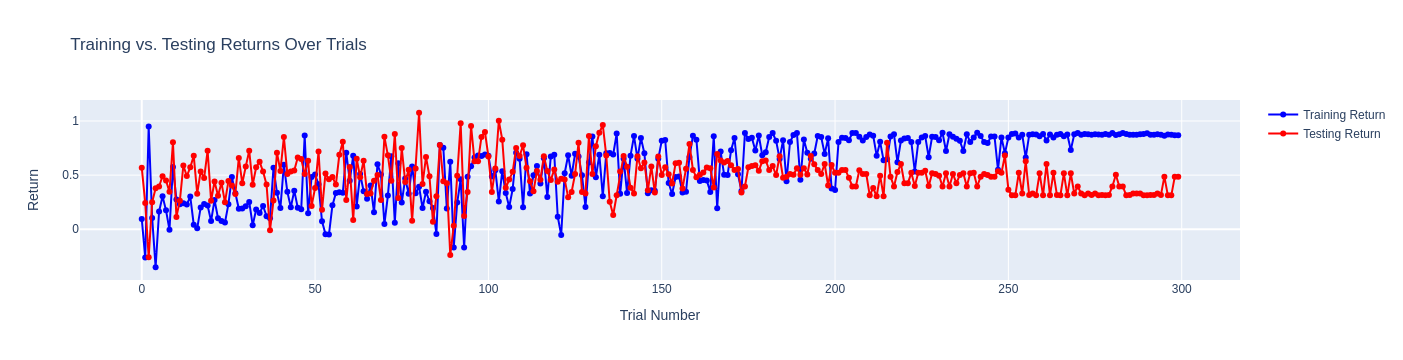

In [143]:
import plotly.graph_objects as go

# Assuming trial_performance['training'] and trial_performance['testing']
# are your data dictionaries for training and testing performance respectively
training_df = pd.DataFrame(trial_performance['training'])
testing_df = pd.DataFrame(trial_performance['testing'])

# Reset index to ensure alignment for comparison, if necessary
training_df.reset_index(drop=True, inplace=True)
testing_df.reset_index(drop=True, inplace=True)

# Create traces for training and testing returns
trace1 = go.Scatter(
    x=training_df.index,
    y=training_df['return'],
    mode='lines+markers',
    name='Training Return',
    marker=dict(color='blue')
)

trace2 = go.Scatter(
    x=testing_df.index,
    y=testing_df['return'],
    mode='lines+markers',
    name='Testing Return',
    marker=dict(color='red')
)

# Define the layout
layout = go.Layout(
    title='Training vs. Testing Returns Over Trials',
    xaxis=dict(title='Trial Number'),
    yaxis=dict(title='Return'),
    hovermode='closest'
)

# Create the figure and add traces
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show the figure
fig.show()


In [148]:
train[('macd', 'macdsignal')].mean().to_numpy()

KeyError: ('macd', 'macdsignal')